<h1><center>Airbnb Host Retention Strategy</center></h1>
<h3><center>Data Analytics Bootcamp Capstone - Summer 2023<center></h3>
<h4><center>Conducted by Luke Geraghty<center></h4>

<h2> <p style="color:blue"><strong>Context:</strong></p> </h2>

- The popularity of hosting on Airbnb's vacation rental platform has grown quickly over the last few years, outpacing the growth of guest demand and creating a listing supply surplus in many regions (especially for short-term rentals). 

- Airbnb determines the number of hosts on the platform based on the number of users with at least one active listing -- they claim to have over 4 million hosts globally.

- Airbnb ended 2022 with their most active listings ever at about 6.6 million, an increase of over 900K listings (+16%) from 2021 (excluding closure of business in China).
  
- Increased listing competition (especially for popular destinations) in 2022 led to lower booking rates, forcing many hosts to lower prices and the minimum nights to stay in an attempt to attract guests.

- Despite these impacts on hosts, one of Airbnb’s strategic priorities in 2023 is to "make hosting mainstream". 
  - They're incentivizing property owners to become hosts with a new feature, Airbnb Setup, making the process to start hosting quicker and easier. 
  
- If these trends continue or worsen, average listing booking rates and host earnings will continue to drop. Many hosts may decide to turn to similar services with less listing competition, like Vrbo (~2 million hosts globally).
  - If many hosts choose to use other services instead, Airbnb could lose significant revenue and market share.
  - A knock-on effect of this could be that guests would have fewer options to choose from on Airbnb, and may also embrace other services. 
  
- One possible way Airbnb could combat this problem is by offering loyalty incentives to their most valuable hosts during periods of extreme marketplace imbalance (listing supply surplus, guest demand shortage) to bolster platform retention and long-term commitment to Airbnb.

<h2> <p style="color:blue"><strong>Problem Statement:</strong></p> </h2>

Which hosts (of short-term rentals) should be incentivized, based on their listing(s) value (revenue to Airbnb), to support host retention on the platform throughout 2023? Additionally, which features of listings have the greatest impact on their value?

<h2> <p style="color:blue"><strong>Airbnb Listing Data Source:</strong></p> </h2>

- Data collected directly from the Inside Airbnb website - http://insideairbnb.com/get-the-data

<h2> <p style="color:blue"><strong>Jump to...</strong></p> </h2>

- [Data Preparation, Cleaning, and Exploration](#cleaning)


- [Data Analysis](#analysis)
    - 1: [Listing Location](#location)
      - 1a: [Revenue by State](#revbystate)
      - 1b: [Seasonality by State](#seasonality)
      - 1c: [Impact of Weather](#weather)
      - 1d: [Location Ratings](#locrating)
    - 2: [Listing Types and Property Quality](#types)
      - 2a: [Room and Property Types](#type)
      - 2b: [Property-Related Ratings](#proprating)
      - 2c: [Listing Amenities](#amenities)
    - 3: [Host Engagement](#engagement)
      - 3a: [Total Active Listings](#active)
      - 3b: [Superhost Status](#superhost)
      - 3c: [Host-Related Ratings](#hostratings)

<a name="cleaning"></a>
<h2> <p style="color:blue"><strong>Data Preparation, Cleaning, and Exploration:</strong></p> </h2> 

<h4> <p style="color:orange"><strong>Import Libraries & Modules:</strong></p> </h4>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import reverse_geocoder as rg
import datetime
import geopandas as gpd
from scipy import stats
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import statsmodels.api as sm
import ast

In [3]:
# float display formatting
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# show all columns in output
pd.set_option('display.max_columns', None)

In [5]:
# load most current df after restarting
abnb_df3 = pd.read_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/abnb_list_data_6.csv', index_col=0)

In [7]:
# modify date column data types
date_cols = ['scrape_date', 'host_since', 'first_review', 'last_review']
abnb_df3[date_cols] = abnb_df3[date_cols].apply(pd.to_datetime)

In [ ]:
# review df
print(abnb_df3.describe())

<h4> <p style="color:orange"><strong>Load Data and Create DataFrame:</strong></p> </h4>

- Original data from 134 CSV files containing data on Airbnb listings in cities across the US (collected from Inside Airbnb website)

In [ ]:
# find csv files in directory, drop unnecessary columns, and replace files before concatenation
files = glob(r'C:\Users\lukeg\OneDrive\Documents\Airbnb Data\detailed_listings_files\*.csv')
drop = ['license','listing_url','scrape_id', 'description','neighborhood_overview','picture_url','host_url',
        'host_location','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count',
        'host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','neighbourhood_cleansed',
        'neighbourhood_group_cleansed','bathrooms_text']

# iterate over files to drop columns specified above and replace with updated files
for f in files:
    df = pd.read_csv(f)
    for col in drop:
        if col in df:
            df = df.drop(col, axis=1)
    df.to_csv(f)

In [5]:
# use glob.glob function to get list of files matching the file path pattern
files_list = sorted(glob.glob(r'C:\Users\lukeg\OneDrive\Documents\Airbnb Data\detailed_listings_files/detailed_listings *.csv'))

# concatenate files in the list to create initial dataframe - raw_abnb_listings_df
raw_abnb_listings_df = pd.concat((pd.read_csv(file).assign(filename=file)
                  for file in files_list), ignore_index=False)

In [6]:
# save dataframe created as new csv file (if needed later for any reason)
raw_abnb_listings_df.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/raw_abnb_listings_df.csv')

In [ ]:
# review dataframe created above
print(raw_abnb_listings_df.head(2))
print(raw_abnb_listings_df.info())
print(raw_abnb_listings_df.describe())

<h4> <p style="color:orange"><strong>Initial Preparation:</strong></p> </h4>

In [39]:
# rename dataframe to abnb_df
abnb_df = raw_abnb_listings_df

In [41]:
# keep all rows, exclude unnecessary columns and rearrange order
abnb_df = abnb_df.loc[:, ['id', 'calendar_last_scraped', 'host_id', 'host_since', 'host_is_superhost', 'property_type', 
                          'room_type', 'amenities', 'bathrooms', 'bedrooms', 'beds', 'accommodates', 'price', 
                          'minimum_nights','maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                          'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                          'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
                          'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                          'review_scores_value', 'calculated_host_listings_count', 
                          'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                          'calculated_host_listings_count_shared_rooms', 'latitude', 'longitude']]

- Notes on columns left out above:
  - 'host_response_rate' and 'host_acceptance_rate' columns were dropped for similar reasons...
    - Host response rate represents the % of guest inquiries responded to within 24 hrs over past 30 days (acceptance rate is % of booking inquiries accepted over 30 days)
    - Too many null values in these columns, and imputed values would not be representative or significant to investigate
  - 'bathrooms' column was dropped because every value in the column missing / null

In [42]:
# rename columns
abnb_df = abnb_df.rename(columns={'id': 'listing_id','calculated_host_listings_count': 'host_total_list_cnt',  
                                  'availability_30': 'avail_30', 'availability_365': 'avail_365', 'availability_60': 
                                  'avail_60', 'availability_90': 'avail_90', 'minimum_nights': 'min_nights',
                                  'maximum_nights': 'max_nights','minimum_nights_avg_ntm': 'avg_min_nights_365',
                                  'maximum_nights_avg_ntm': 'avg_max_nights_365','calendar_last_scraped': 'scrape_date',
                                  'review_scores_rating': 'overall_rating', 'review_scores_accuracy': 'accuracy_rating',
                                  'review_scores_cleanliness': 'cleanliness_rating', 'review_scores_checkin': 'checkin_rating',
                                  'review_scores_communication': 'comms_rating', 'review_scores_location': 'loc_rating',
                                  'review_scores_value': 'value_rating', 'number_of_reviews_ltm': 'review_cnt_l12m',
                                  'number_of_reviews_l30d': 'review_cnt_l30d', 'calculated_host_listings_count_entire_homes':
                                  'host_entire_home_cnt', 'calculated_host_listings_count_private_rooms': 
                                  'host_private_room_cnt', 'calculated_host_listings_count_shared_rooms': 'host_shared_room_cnt'})

In [516]:
# drop avg_max_/_min_nights_365 columns as well - not needed
abnb_df.drop(['avg_max_nights_365', 'avg_min_nights_365'], axis=1, inplace=True)

In [43]:
# add columns for city / state, using lat and long

# combine lat and long lists into single list of tuples
coordinates2 = list(zip(abnb_df['latitude'], abnb_df['longitude']))

# perform reverse geocoding
results = rg.search(coordinates2)

# get city & state names from results and insert in abnb_df
city = [result['name'] for result in results] 
state = [result['admin1'] for result in results]
abnb_df.insert(2, 'city', city) 
abnb_df.insert(3, 'state', state)

In [120]:
# drop rows with listings in Baja California (not in USA)
abnb_df.drop(abnb_df[abnb_df['state'] == "Baja California"].index, axis=0, inplace=True)

In [432]:
# replace full state names with their abbreviations using dictionary and map function
state_abbreviations = {'Texas': 'TX','California': 'CA','New York': 'NY','New Jersey': 'NJ','Tennessee': 'TN',
                       'Oregon': 'OR','Washington': 'WA','Louisiana': 'LA','Nevada': 'NV','Arizona': 'AZ','Illinois': 'IL',
                       'Indiana': 'IN','Massachusetts': 'MA','Hawaii': 'HI','Ohio': 'OH','Colorado': 'CO','Minnesota': 'MN',
                       'Wisconsin': 'WI','Maryland': 'MD','Washington, D.C.': 'DC','Virginia': 'VA','North Carolina': 'NC',
                       'Rhode Island': 'RI','Connecticut': 'CT','Montana': 'MT','Florida': 'FL'}

abnb_df['state'] = abnb_df['state'].map(state_abbreviations)

<h4> <p style="color:orange"><strong>Modify Data Types:</strong></p> </h4>

In [ ]:
# review column data types
abnb_df.dtypes

In [46]:
# remove dollar sign and comma from price values and convert to float
abnb_df['price'] = abnb_df['price'].astype(str).str.replace(r'[$,]', '',regex=True).astype(float)

In [581]:
# convert columns with dates to datetime type
date_cols = ['scrape_date', 'host_since', 'first_review', 'last_review']
abnb_df[date_cols] = abnb_df[date_cols].apply(pd.to_datetime)

In [49]:
# in host_is_superhost and has_availability, replace t and f with 1 and 0
abnb_df[['host_is_superhost', 'has_availability']] = abnb_df[['host_is_superhost', 'has_availability']].replace({'t': 1, 'f': 0})

In [50]:
# save progress on abnb_df after changes as csv
abnb_df.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/abnb_list_data_1.csv')

<h4> <p style="color:orange"><strong>Null Value Removal & Imputation:</strong></p> </h4>

In [ ]:
# count null values by column
print(abnb_df.isna().sum())

In [52]:
# drop rows with null values in columns - not many null rows / hard to replace
abnb_df.dropna(subset=['host_since','host_is_superhost','avg_min_nights_365', 'avg_max_nights_365'], inplace=True)

In [55]:
# drop bathrooms column - all values null
abnb_df.drop('bathrooms', axis=1, inplace=True)

In [78]:
# save before changes to null values in beds and bedrooms columns
abnb_df.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/abnb_list_data_2.csv')

In [ ]:
# examine statistics of null rows in bedrooms column
# create bool mask for nulls in bedrooms
null_mask = abnb_df['bedrooms'].isnull()
# filter for rows that have null values to find out why
abnb_df[null_mask].describe()

Notes on dealing with null values in bedrooms column below:

- Using np.where() replaces null values in bedrooms, if the condition is met, with the row's value of beds (multiplied by the overall average ratio of bedrooms to beds 
  - Non-null values left unchanged
- Then, for listings with 0 beds, remaining null values in bedrooms column replaced with 0

In [103]:
# replace null values in bedrooms column
bedroom_bed_ratio = abnb_df['bedrooms'].mean() / abnb_df['beds'].mean()

abnb_df['bedrooms'] = np.where(abnb_df['bedrooms'].isnull() & abnb_df['beds'].notnull(), round((abnb_df['beds'] * bedroom_bed_ratio)), abnb_df['bedrooms'])
abnb_df['bedrooms'].fillna(0, inplace=True)

In [ ]:
# examine rows with null values in beds column

# create bool mask for nulls in beds
null_mask = abnb_df['beds'].isnull()
# filter for rows that have null values to find out why
abnb_df[null_mask].describe()

In [111]:
# replace null values in beds using similar method as bedrooms column
bed_bedroom_ratio = abnb_df['beds'].mean() / abnb_df['bedrooms'].mean()
abnb_df['beds'] = np.where(abnb_df['beds'].isnull(), round((abnb_df['bedrooms'] * bed_bedroom_ratio)), abnb_df['beds'])

In [127]:
# save progress on abnb_df as csv after changes to null values and state column (haven't changed nulls for ratings yet)
abnb_df.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/abnb_list_data_3.csv')

Notes on dealing with null values in review & rating columns below:

- Still many null values in ratings columns of abnb_df 
  - Filter out rows that have listings with no reviews / ratings (rename filtered df to abnb_df2)
    - Can't just replace ratings with something like the mean rating of listings in the city as the listings hadn't received any reviews yet

In [576]:
# count rows with 0 total reviews over listing's lifetime
len(abnb_df[abnb_df['number_of_reviews'] == 0])

213051

In [ ]:
# review rows / listings without any reviews
abnb_df[abnb_df['number_of_reviews'] == 0].describe()

In [596]:
# make new df (abnb_df2), dropping rows without reviews
abnb_df2 = abnb_df[abnb_df['number_of_reviews'] != 0].copy()

In [597]:
# check number of rows removed
a = len(abnb_df)
b = len(abnb_df2)

print('Rows removed with 0 reviews for listing:', a-b)

Rows removed with 0 reviews for listing: 213051


In [610]:
# drop remaining rows with null values in any of the ratings columns
abnb_df2 = abnb_df2.dropna(subset=['accuracy_rating', 'cleanliness_rating', 'checkin_rating', 'comms_rating', 
                                   'loc_rating', 'value_rating'], how='any')

In [ ]:
# confirm there are no remaining null / missing values
print(abnb_df2.isna().sum())

In [614]:
# save abnb_df2 to csv file after dealing with all null values
abnb_df2.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/abnb_list_data_4.csv')

<h4> <p style="color:orange"><strong>Remove Long-Term Rental Listings and Extreme Price Outliers:</strong></p> </h4>

- Remove listings that are available for long-term rental (only interested in short-term rentals)
  - A stay of 28 nights or more is considered long-term
- Remove listings with extreme nightly price outliers as well
  - Keeping listings with prices in the following range: \\$10 to \\$1,000 (~99% of listings)

In [617]:
# filter to include only short-term rental listings
abnb_df3 = abnb_df2[(abnb_df2['max_nights'] <= 28) & (abnb_df2['min_nights'] <= 28)]

In [723]:
# proportion of listings with prices over 10 and less than or equal to 1000 per night
list_prices_normal = abnb_df3[(abnb_df3['price'] > 10) & (abnb_df3['price'] <= 1000)]['listing_id'].nunique()
unique_listings_cnt = abnb_df3['listing_id'].nunique()
print('% of listings with price > 10 and <= 1k in abnb_df3:', '\n\n', list_prices_normal/unique_list_cnt)

% of listings with price > 0 and <= 1k in abnb_df3: 

 0.9903009465597011


- 99% of listings in abnb_df3 have prices > 10 and <= 1k per night -- removing extreme outliers outside this range

In [733]:
# filter abnb_df3 by price
abnb_df3 = abnb_df3[(abnb_df3['price'] > 10) & (abnb_df3['price'] <= 1000)]

In [738]:
# save changes to abnb_df3 as new file
abnb_df3.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Data/abnb_data_files/abnb_list_data_5.csv')

<h4> <p style="color:orange"><strong>Add Calculated Columns (Bookings & Revenue):</strong></p> </h4>


- Breakdown of Airbnb's revenue per booking from service fees ([Source - Airbnb](https://www.airbnb.com/help/article/1857))
  - 1) Split-fee: this fee structure is the most common and is split between the host and the guest
    - Most hosts pay a 3% fee
    - Most guests pay a fee of about 14%
    - Resulting in 17% of total booking price as revenue for Airbnb 
  - 2) Host-only fee: with this structure, the entire fee is deducted from the host payout - applies to traditional hospitality listings, such as hotels and serviced apartments
    - Fee is typically 14–16% (using 15%)
    
 
- Using the following assumptions for calculations
  - Similar assumptions used by Inside Airbnb ([Source - Inside Airbnb](http://insideairbnb.com/data-assumptions))
  - 50% of review rate can be used as an estimate of a listing's total number of bookings 
    - going to use 25% instead (result using 50% rate were far from overall average for listings from Airbnb statistics)
  - Using approximate estimates for average length of stay (no reliable public information for on the length of Airbnb stays in specific cities)
    - Values used for average length of stay based on Airbnb's statistics by room type - found here [Source](https://ateasebnb.com/how-long-does-the-average-airbnb-guest-stay/)
  - Avg. length of stay * number of bookings used to estimate a listing's booking rate over a given time period

In [812]:
# average length of stay in listing
abnb_df3['avg_stay_length'] = np.where((abnb_df3['room_type'].isin(['Hotel room', 'Entire home/apt'])) & (abnb_df3['min_nights'] < 4), 3.7,
                                      np.where((abnb_df3['room_type'] == 'Private room') & (abnb_df3['min_nights'] < 4), 3.2,
                                               np.where((abnb_df3['room_type'] == 'Shared room') & (abnb_df3['min_nights'] < 3), 2.7, abnb_df3['min_nights'])))

In [744]:
# total days listing active (date of last review - date host joined)
abnb_df3['days_list_active'] = (abnb_df3['last_review'] - abnb_df3['host_since']).dt.days

In [748]:
# 5 rows had negative results for days listing active - using last_review - first_review for these cases
mask = abnb_df3['last_review'] < abnb_df3['host_since']
abnb_df3.loc[mask, 'days_list_active'] = (abnb_df3['last_review'] - abnb_df3['first_review']).dt.days

In [824]:
# estimated number of nights booked over listing's lifetime (estimated total bookings * avg stay length)
abnb_df3['nights_booked_total'] = (abnb_df3['number_of_reviews'] / 0.25) * abnb_df3['avg_stay_length']

In [825]:
# lifetime booking rate (total nights booked / total days listing active)
abnb_df3['list_book_rate'] = (abnb_df3['nights_booked_total'] / abnb_df3['days_list_active']).clip(upper=0.95)

In [948]:
# calculate reviews per year
abnb_df3['reviews_per_yr'] = abnb_df3['reviews_per_month'] * 12

In [826]:
# estimated nights booked annually
abnb_df3['nights_booked_yr'] = abnb_df3['list_book_rate'] * 365

In [740]:
# revenue per night (nightly price multiplied by service fee, which depends on the type of property)
abnb_df3['revenue_nightly'] = np.where(abnb_df3['property_type'].str.contains('hotel|serviced apartment|aparthotel',case=False),
                                       abnb_df3['price'] * 0.15, abnb_df3['price'] * 0.17)

In [827]:
# estimated revenue per year for each listing
abnb_df3['approx_revenue_yr'] = abnb_df3['nights_booked_yr'] * abnb_df3['revenue_nightly']

In [952]:
# reorder columns
abnb_df3 = abnb_df3.loc[:, ['scrape_date','listing_id', 'host_id', 'host_since', 'host_is_superhost', 
                            'city', 'state', 'property_type', 'room_type', 'amenities',
                            'bedrooms', 'beds', 'accommodates', 'price', 'min_nights', 'max_nights',
                            'has_availability', 'avail_30', 'avail_60', 'avail_90', 'avail_365',
                            'number_of_reviews', 'reviews_per_month', 'review_cnt_l30d','reviews_per_yr', 
                            'review_cnt_l12m', 'days_list_active', 'first_review', 'last_review', 'overall_rating',
                            'accuracy_rating', 'cleanliness_rating', 'checkin_rating',
                            'comms_rating', 'loc_rating', 'value_rating', 'host_total_list_cnt',
                            'host_entire_home_cnt', 'host_private_room_cnt', 'host_shared_room_cnt', 
                            'nights_booked_total', 'list_book_rate', 'nights_booked_yr', 'revenue_nightly', 
                            'approx_revenue_yr', 'approx_revenue_month', 'avg_stay_length', 'latitude', 'longitude']]

Note: Noticed some states only have data for less than 100 unique listings remaining 
  - Removing those states - much less listing data than other states...

In [ ]:
# count of remaining unique listings by state
state_unique_listings = abnb_df3.groupby('state')['listing_id'].nunique().sort_values(ascending=False)
print('Unique Listings by State:','\n\n',state_unique_listings)

In [933]:
# count rows to be dropped
abnb_df3[abnb_df3['state'].isin(['MT','AZ','WI','CT','IN','VA'])].shape

(403, 48)

In [934]:
# drop rows from abnb_df3 with states that have less than 100 unique listings - 'MT','AZ','WI','CT','IN','VA'
abnb_df3 = abnb_df3[~abnb_df3['state'].isin(['MT', 'AZ', 'WI', 'CT', 'IN', 'VA'])]

In [955]:
# sort listings in chronological order using scrape_date column
abnb_df3 = abnb_df3.sort_values('scrape_date')

In [70]:
# save progress on abnb_df3 after new columns added and dropping states with little data
abnb_df3.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/abnb_list_data_6.csv')

<a name="analysis"></a> 
<h2> <p style="color:blue"><strong>Data Analysis:</strong></p> </h2>


**Investigate which short-term rental hosts Airbnb should focus on retaining, based on the value of their listings to Airbnb. By determining aspects of listings that influence price (thus revenue) most significantly, can identify segment of hosts with valuable listings to target with platform retention efforts.**


**1) Location**

**2) Listing Type and Quality**

**3) Host Engagement**



*Note: After analysis on the state level, will focus on listings in California (CA has the most unique listings and cities of any state)*

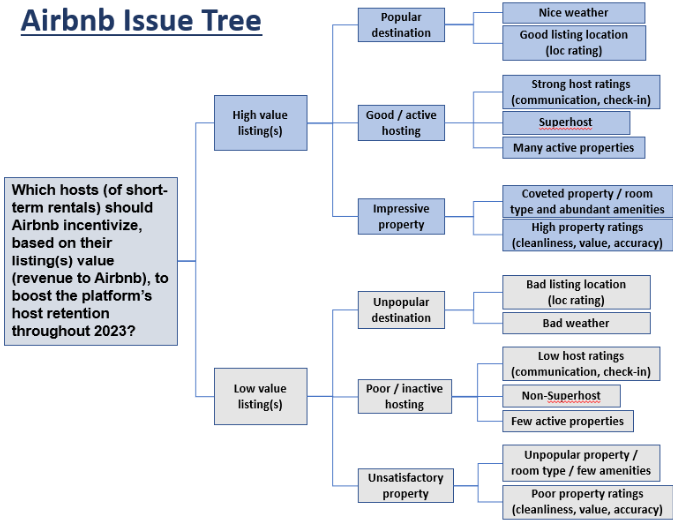

<a name="location"></a>
<h3> <p style="color:blue"><strong>1) Location:</strong></p> </h3>

<a name="revbystate"></a>
<p style="color:orange"><strong>1a - Revenue by State:</strong></p>

- Identify states (of those included) that generate the most revenue per listing on average

In [21]:
# average nightly revenue per listing by state
state_avg_rev = abnb_df3.groupby('state')[['approx_revenue_yr','revenue_nightly']].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
print('Top 5 States - Avg. Nightly Revenue per Listing:\n',state_avg_rev[['state','revenue_nightly']].head(5),'\n\n')

# average annual revenue per listing by state
state_avg_rev = state_avg_rev.sort_values(by='approx_revenue_yr', ascending=False).reset_index()
print('Top 5 States - Avg. Annual Revenue per Listing:\n', state_avg_rev[['state','approx_revenue_yr']].head(5))

Top 5 States - Avg. Nightly Revenue per Listing:
   state  revenue_nightly
0    HI            48.91
1    RI            48.19
2    TN            36.64
3    NV            36.10
4    CA            33.02 


Top 5 States - Avg. Annual Revenue per Listing:
   state  approx_revenue_yr
0    TN            5982.78
1    MA            5563.55
2    NC            5081.02
3    RI            5072.87
4    CA            4993.48


**Average Revenue per Listing by State:**

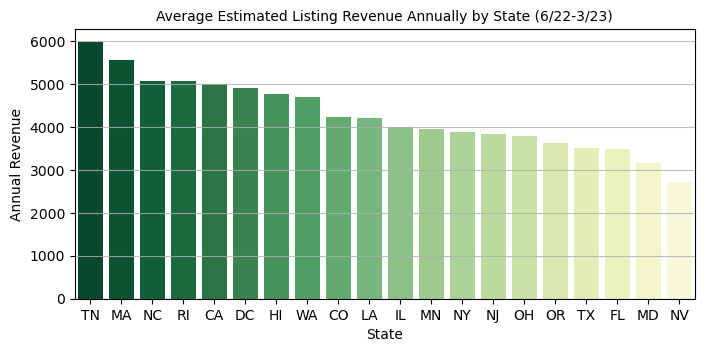

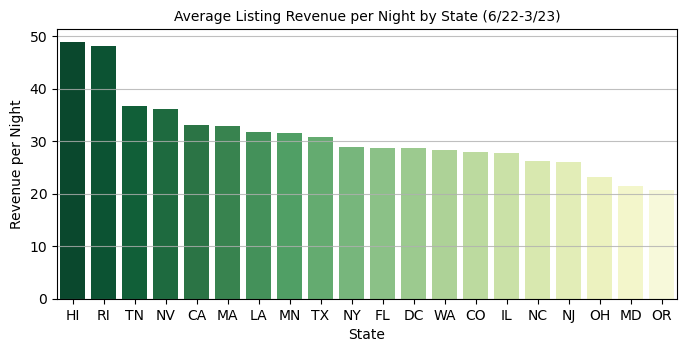

In [11]:
# plot avg annual revenue per listing by state
plt.figure(figsize=(8,3.5))
sns.barplot(data=state_avg_rev, x='state', y='approx_revenue_yr', palette='YlGn_r')
plt.title('Average Estimated Listing Revenue Annually by State (6/22-3/23)', fontsize=10)
plt.xlabel('State')
plt.ylabel('Annual Revenue')
plt.grid(True, alpha=0.8, axis='y')
plt.show()

# plot avg nightly revenue per listing by state
plt.figure(figsize=(8,3.5))
sorted_rev_night = state_avg_rev.sort_values(by='revenue_nightly', ascending=False)
sns.barplot(data=sorted_rev_night, x='state', y='revenue_nightly', palette='YlGn_r')
plt.title('Average Listing Revenue per Night by State (6/22-3/23)', fontsize=10)
plt.xlabel('State')
plt.ylabel('Revenue per Night')
plt.grid(True, alpha=0.8, axis='y')
plt.show()

**Geographic Heatmap - Average Annual Revenue per Listing:**
- Shapefile source: [US Census Bureau](https://www2.census.gov/geo/tiger/TIGER2022/STATE/)

In [ ]:
# read the shapefile for states
state_shapefile = 'C:/Users/lukeg/OneDrive/Documents/Airbnb Project/Geo Files/tl_2022_us_state.shp'
state_gdf = gpd.read_file(state_shapefile)

# rename District of Columbia to be DC in state_gdf
state_gdf['NAME'] = state_gdf['NAME'].replace('District of Columbia', 'DC')

# merge geo df with state income df
state_geo_df = state_gdf.merge(state_avg_rev, left_on='STUSPS', right_on='state')

# review
state_geo_df.head()

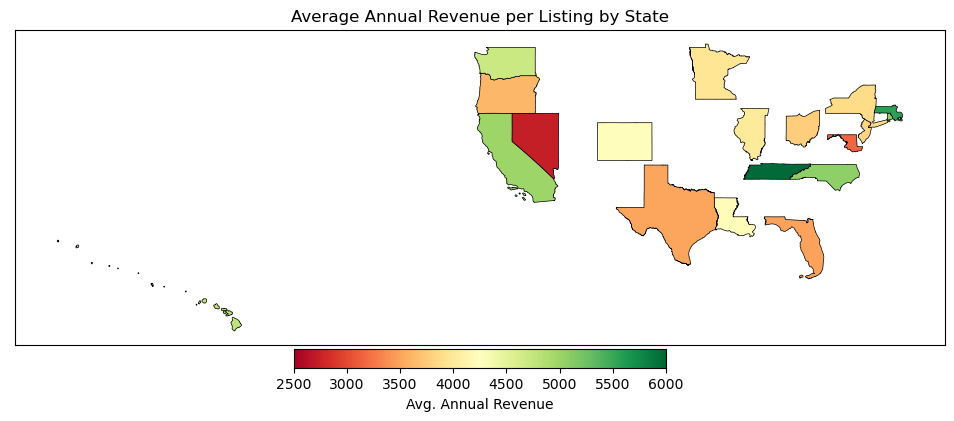

In [514]:
from matplotlib.colors import Normalize

# create geo heatmap showing avg annual revenue per listing by state
fig, ax = plt.subplots(figsize=(12,10))
p = state_geo_df.plot(column='approx_revenue_yr', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='black')  
ax.set_title('Average Annual Revenue per Listing by State', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])

# add colorbar (legend)
norm = Normalize(vmin=2500, vmax=6000)
cb = plt.colorbar(p.collections[0], shrink=0.4, orientation='horizontal', pad=0.005)
cb.mappable.set_norm(norm)  
cb.set_label('Avg. Annual Revenue', fontsize=10)

plt.show()

- <span style="color:green"><strong>Tennessee lead all states in average annual revenue per listing (\\$5,982.78), followed by Massachusetts (\\$5,563.55)</span>

- <span style="color:green"><strong>However, listings in HI had the highest average revenue per night (\\$48.91), followed by Rhode Island (\\$48.19)</span>

  - As the calculation for annual revenue takes booking rates into account, this suggests that generally listings in TN had stronger booking rates than those in HI

<a name="seasonality"></a>
<h4> <p style="color:orange"><strong>1b - Revenue Seasonality by State:</strong></p> </h4>

- Which states exhibit the most listing revenue seasonality throughout the year? The least?
  - Listings in states with minimal seasonality throughout the year are preferable, as they should provide more consistent revenue

In [ ]:
# add column for month/year to abnbdf3
abnb_df3['month_year'] = abnb_df3['scrape_date'].dt.to_period('M')

In [823]:
# create new df for avg listing revenue per night, grouped by state and month/year
state_income_monthly = abnb_df3.groupby(['state', 'month_year']).agg({'revenue_nightly': 'mean'}).reset_index()
# rename column
state_income_monthly.rename(columns={'revenue_nightly': 'avg_revenue_night'}, inplace=True)
# review
state_income_monthly

,state,month_year,avg_revenue_night
0,CA,2022-06,34.19
1,CA,2022-09,33.62
2,CA,2022-12,32.09
3,CA,2023-03,32.02
4,CO,2022-06,29.68
...,...,...,...
86,TX,2023-03,34.51
87,WA,2022-06,31.25
88,WA,2022-09,30.19
89,WA,2022-12,26.35


In [824]:
# csv files downloaded for TX included more months of the year than all other states, as shown below
print(state_income_monthly[state_income_monthly['state'] == 'TX']['month_year'].unique(),'\n')
print(state_income_monthly[state_income_monthly['state'] != 'TX']['month_year'].unique())

['2022-05' '2022-06' '2022-07' '2022-08' '2022-09' '2022-10' '2022-11'
 '2022-12' '2023-01' '2023-02' '2023-03'] 

['2022-06' '2022-09' '2022-12' '2023-03' '2023-04' '2023-01']


In [825]:
# filter out months without data from all states included
months = ['2022-06', '2022-09', '2022-12', '2023-03']
state_income_monthly = state_income_monthly[state_income_monthly['month_year'].isin(months)]
state_income_monthly['month_year'].unique()

array(['2022-06', '2022-09', '2022-12', '2023-03'], dtype=object)

In [842]:
# review descriptive statistics to explore the variation in each state's distribution of avg listing revenue over time
state_income_monthly.groupby(['state']).describe()

avg_revenue_night                                         
                  count  mean  std   min   25%   50%   75%   max
state                                                           
CA                 4.00 32.98 1.09 32.02 32.07 32.85 33.76 34.19
CO                 4.00 27.97 1.22 26.85 27.28 27.68 28.38 29.68
DC                 4.00 28.70 1.95 26.65 27.37 28.58 29.91 31.00
FL                 4.00 28.82 3.68 24.33 26.93 28.97 30.86 33.02
HI                 4.00 48.90 1.50 46.68 48.66 49.51 49.75 49.92
IL                 4.00 27.73 2.64 25.16 25.61 27.70 29.81 30.35
LA                 4.00 31.82 2.44 29.57 30.69 31.21 32.34 35.29
MA                 4.00 32.08 4.09 27.50 29.20 32.52 35.40 35.78
MD                 4.00 21.40 0.53 20.61 21.30 21.60 21.69 21.78
MN                 4.00 31.64 1.29 29.71 31.48 32.21 32.38 32.43
NC                 4.00 26.27 1.15 24.82 25.89 26.31 26.70 27.63
NJ                 4.00 26.75 3.39 24.37 24.70 25.46 27.51 31.72
NV                 4.00 36.09 0.76 35.01 35.88 36.31 36.52 36.74
NY                 4.00 28.95 1.93 26.63 27.76 29.19 30.38 30.81
OH                 4.00 23.17 1.46 21.28 22.53 23.33 23.97 24.75
OR                 4.00 20.61 1.37 19.27 19.71 20.38 21.28 22.40
RI                 4.00 47.36 4.24 42.49 44.97 47.26 49.65 52.44
TN                 4.00 36.75 2.87 32.65 35.87 37.62 38.50 39.11
TX                 4.00 32.69 1.25 31.67 32.12 32.28 32.85 34.51
WA                 4.00 28.29 2.87 25.36 26.10 28.27 30.46 31.25

In [843]:
# group by state and calculate range of state's avg revenue per night
state_rev_difference = state_income_monthly.groupby('state')['avg_revenue_night'].agg(lambda x: x.max() - x.min())
state_rev_difference = state_rev_difference.sort_values(ascending=False)

print('States with widest range of revenue per night from 6/22 to 3/23:', '\n', 
      state_rev_difference.head(5), '\n')
print('States with smallest range of revenue per night:', '\n', 
      state_rev_difference.tail(5))

States with widest range of revenue per night from 6/22 to 3/23: 
 state
RI   9.95
FL   8.69
MA   8.27
NJ   7.35
TN   6.46
Name: avg_revenue_night, dtype: float64 

States with smallest range of revenue per night: 
 state
NC   2.81
MN   2.71
CA   2.17
NV   1.74
MD   1.17
Name: avg_revenue_night, dtype: float64


- A relatively high standard deviation and wide spread for the distribution of revenue over time reveals the possibility of volatile income to Airbnb from listings for a given state
  - RI, FL, MA, NJ, and TN all had a high standard deviation and wide spread of nightly revenue per listing, relative to the other states

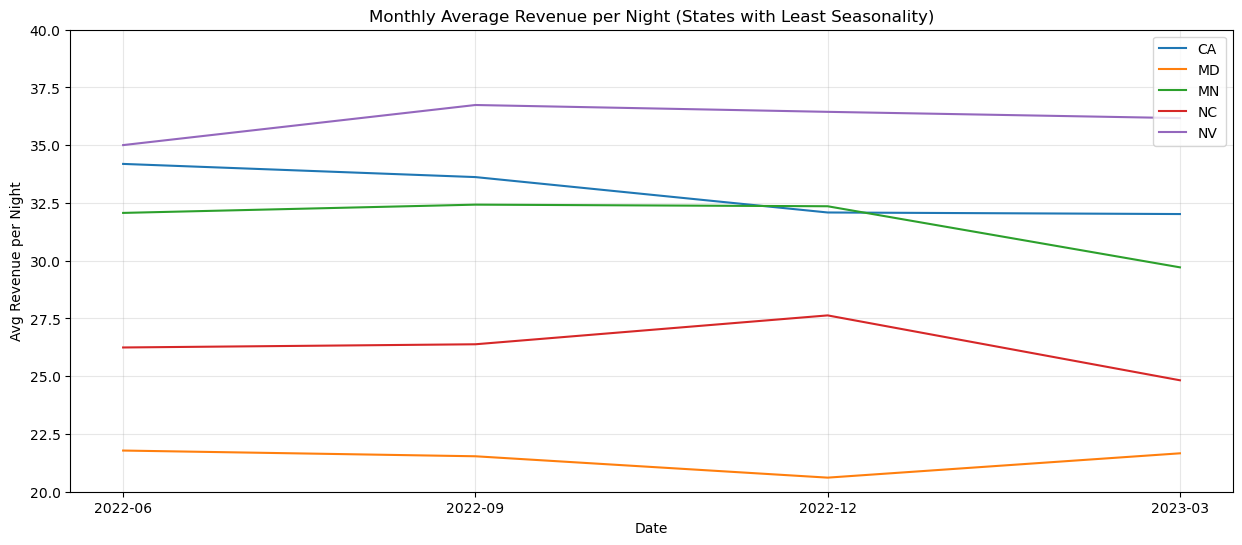

In [832]:
# line plot showing avg nightly revenue for each state by month
select_states = ['NC', 'MN', 'CA', 'NV', 'MD']
filt_state_inc_mthly = state_income_monthly[state_income_monthly['state'].isin(select_states)].copy()

# convert 'month' to string type
filt_state_inc_mthly['month_year'] = filt_state_inc_mthly['month_year'].astype(str)

# get unique states to plot seperate lines
states = filt_state_inc_mthly['state'].unique()

plt.figure(figsize=(15,6))

for state in states:
    data = filt_state_inc_mthly[filt_state_inc_mthly['state'] == state]
    plt.plot(data['month_year'], data['avg_revenue_night'], label=state)

plt.ylim(20,40)
plt.grid(True, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Avg Revenue per Night')
plt.title('Monthly Average Revenue per Night (States with Least Seasonality)')
plt.legend(loc='upper right')
plt.show()

- Listings in the states shown above offer a stable stream of revenue throughout the year
  - *Does not mean their listings make the most income in total* - but revenue from their listings is consistent

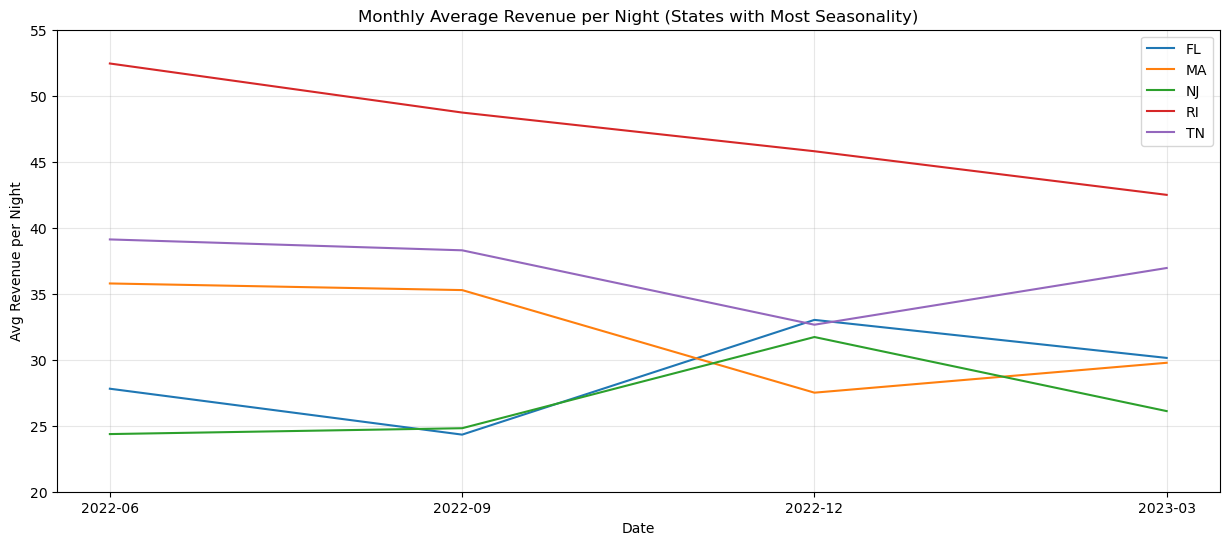

In [834]:
# line plot showing avg nightly revenue for each state by month

select_states = ['TN', 'RI', 'NJ', 'MA', 'FL']

filt_state_inc_mthly = state_income_monthly[state_income_monthly['state'].isin(select_states)].copy()

# make 'month' string data type
filt_state_inc_mthly['month_year'] = filt_state_inc_mthly['month_year'].astype(str)

# get unique states to plot seperate lines
states = filt_state_inc_mthly['state'].unique()

plt.figure(figsize=(15,6))

for state in states:
    data = filt_state_inc_mthly[filt_state_inc_mthly['state'] == state]
    plt.plot(data['month_year'], data['avg_revenue_night'], label=state)

plt.ylim(20,55)
plt.grid(True, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Avg Revenue per Night')
plt.title('Monthly Average Revenue per Night (States with Most Seasonality)')
plt.legend(loc='upper right')
plt.show()

As shown above, there's more seasonality in avg. revenue per night for these states

- Generally, listings in states that generate more stable revenue throughout the year should be considered more valuable to Airbnb
  - The avg nightly revenue from listings in FL and NJ is relatively low in 06/22, 09/22, and 03/23, while peaking in 12/22
  - The avg nightly revenues in MA and TN are relatively high in 06/22 and 09/22, drop off in 12/23, then return to around their average in 03/23
  - For some reason, the avg nightly revenue from listings in RI starts high in 06/22, around 53 per night, but drops consistently over time to a low of about 43 per night in 03/23

<a name="weather"></a>
<h4> <p style="color:orange"><strong>1c - Impact of Weather:</strong></p> </h4>

- Is there a relationship between a state's weather and the amount of revenue from listings in the state?
  - Based on state's average temperature (average high, low, overall temps) and precipitation (inches) from 1991-2020

In [11]:
# read state average weather data
state_weather_avgs = pd.read_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/weather_files/state_annual_weather_averages.csv')

In [12]:
state_weather_avgs.head()

,state,avg_high,avg_temp,avg_low,avg_precip_inches
0,AL,75.00,63.60,52.20,56.90
1,AK,35.50,28.00,20.40,37.60
2,AZ,75.30,61.10,46.80,11.60
3,AR,71.80,61.00,50.20,52.50
4,CA,71.50,59.00,46.50,22.30


In [15]:
# merge state average weather and revenue dataframes (state rev df from section 1a)
state_rev_weath = state_avg_rev.merge(state_weather_avgs,
                                      on='state',how='inner').sort_values(by='revenue_nightly',ascending=False)
state_rev_weath.head()

,state,approx_revenue_yr,revenue_nightly,avg_high,avg_temp,avg_low,avg_precip_inches
5,HI,4775.62,48.91,80.40,73.50,66.60,43.20
3,RI,5072.87,48.19,60.00,50.70,41.30,49.10
0,TN,5982.78,36.64,69.40,58.50,47.50,55.10
18,NV,2732.23,36.10,64.60,51.00,37.40,10.20
4,CA,4993.48,33.02,71.50,59.00,46.50,22.30


In [16]:
# save state_rev_weath to csv
state_rev_weath.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/state_weather_revenue_df.csv')

**Bar Plots of Average Temp / Precip vs Average Revenue by State:**

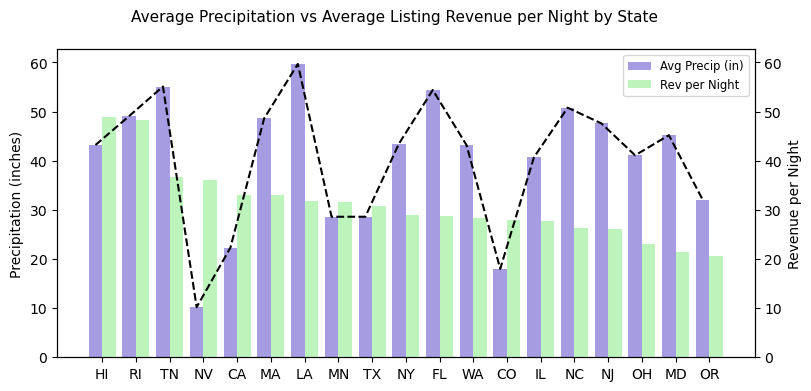

In [858]:
# filter dataframe for columns needed
avg_prec_df = state_rev_weath[['state', 'avg_precip_inches', 'revenue_nightly']].sort_values('revenue_nightly', ascending=False)
# create fig / axes
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx() 
# number of bars and width
numbars = len(avg_prec_df)
bar_width = 0.4 
# x-axis position for precipitation and revenue bars
prec_pos = range(1, numbars+1)
rev_pos = [x + bar_width for x in prec_pos]
# plot prec bars on ax1 / revenue bars on ax2
ax1.bar(prec_pos, avg_prec_df['avg_precip_inches'], width=bar_width, label='Avg Precip (in)', color='slateblue', alpha=0.6)
ax2.bar(rev_pos, avg_prec_df['revenue_nightly'], width=bar_width, label='Rev per Night', color='lightgreen', alpha=0.6)
# add line to track revenue
ax2.plot(prec_pos, avg_prec_df['avg_precip_inches'], color='black', linestyle='--')
# set axis ticks / labels / titles
ax1.set_xticks([x + bar_width/2 for x in prec_pos])
ax1.set_xticklabels(avg_prec_df['state'], fontsize=10)
ax1.set_ylabel('Precipitation (inches)', fontsize=10)
ax2.set_ylabel('Revenue per Night', fontsize=10) 
fig.suptitle('Average Precipitation vs Average Listing Revenue per Night by State', fontsize=11)
# add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='small')
plt.show()

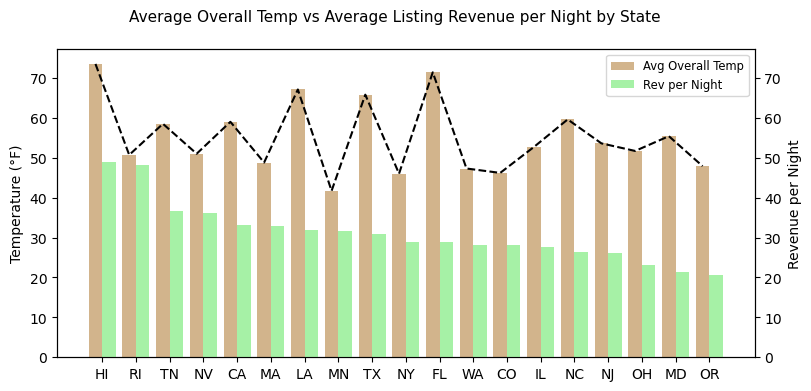

In [859]:
avg_temp_df = state_rev_weath[['state', 'avg_temp', 'revenue_nightly']].sort_values('revenue_nightly', ascending=False)
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx() 
numbars = len(avg_temp_df)
bar_width = 0.4 
temp_pos = range(1, numbars+1)
rev_pos = [x + bar_width for x in temp_pos]
ax1.bar(temp_pos, avg_temp_df['avg_temp'], width=bar_width, label='Avg Overall Temp', color='tan')
ax2.bar(rev_pos, avg_temp_df['revenue_nightly'], width=bar_width, label='Rev per Night', color='lightgreen', alpha=0.8)
ax2.plot(temp_pos, avg_temp_df['avg_temp'], color='black', linestyle='--')
ax1.set_xticks([x + bar_width/2 for x in temp_pos])
ax1.set_xticklabels(avg_temp_df['state'], fontsize=10)
ax1.set_ylabel('Temperature (°F)', fontsize=10)
ax2.set_ylabel('Revenue per Night', fontsize=10) 
fig.suptitle('Average Overall Temp vs Average Listing Revenue per Night by State', fontsize=11)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='small')
plt.show()

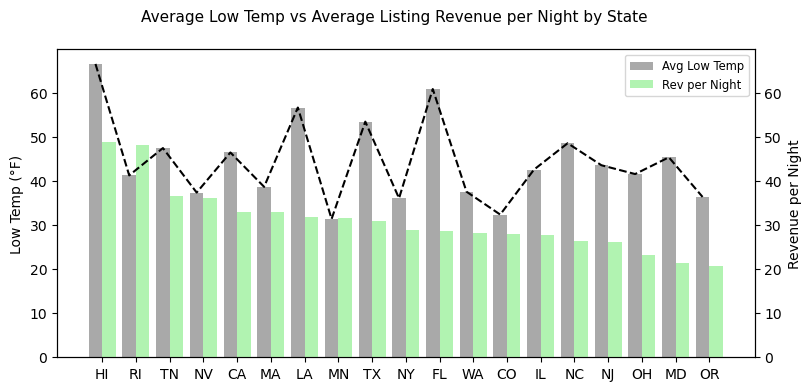

In [860]:
avg_low_df = state_rev_weath[['state', 'avg_low', 'revenue_nightly']].sort_values('revenue_nightly', ascending=False)
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx() 
numbars = len(avg_low_df)
bar_width = 0.4 
temp_pos = range(1, numbars+1)
rev_pos = [x + bar_width for x in temp_pos]
ax1.bar(temp_pos, avg_low_df['avg_low'], width=bar_width, label='Avg Low Temp', color='darkgray')
ax2.bar(rev_pos, avg_low_df['revenue_nightly'], width=bar_width, label='Rev per Night', color='lightgreen', alpha=0.7)
ax2.plot(temp_pos, avg_low_df['avg_low'], color='black', linestyle='--')
ax1.set_xticks([x + bar_width/2 for x in temp_pos])
ax1.set_xticklabels(avg_low_df['state'], fontsize=10)
ax1.set_ylabel('Low Temp (°F)', fontsize=10)
ax2.set_ylabel('Revenue per Night', fontsize=10) 
fig.suptitle('Average Low Temp vs Average Listing Revenue per Night by State', fontsize=11)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='small')
plt.show()

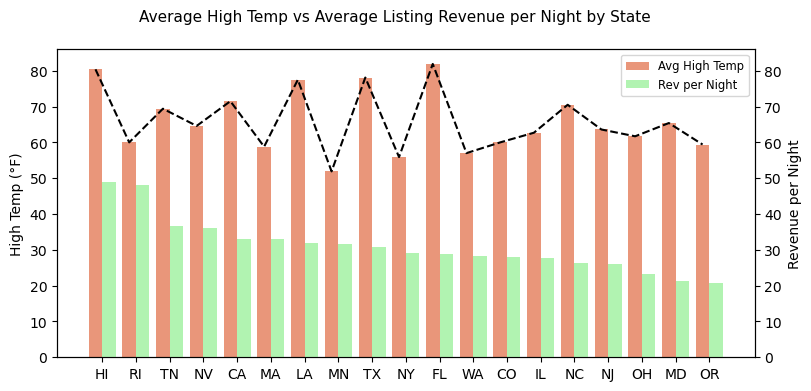

In [861]:
avg_high_df = state_rev_weath[['state', 'avg_high', 'revenue_nightly']].sort_values('revenue_nightly', ascending=False)
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx() 
numbars = len(avg_high_df)
bar_width = 0.4 
temp_pos = range(1, numbars+1)
rev_pos = [x + bar_width for x in temp_pos]
ax1.bar(temp_pos, avg_high_df['avg_high'], width=bar_width, label='Avg High Temp', color='darksalmon')
ax2.bar(rev_pos, avg_high_df['revenue_nightly'], width=bar_width, label='Rev per Night', color='lightgreen', alpha=0.7)
ax2.plot(temp_pos, avg_high_df['avg_high'], color='black', linestyle='--')
ax1.set_xticks([x + bar_width/2 for x in temp_pos])
ax1.set_xticklabels(avg_high_df['state'], fontsize=10)
ax1.set_ylabel('High Temp (°F)', fontsize=10)
ax2.set_ylabel('Revenue per Night', fontsize=10) 
fig.suptitle('Average High Temp vs Average Listing Revenue per Night by State', fontsize=11)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='small')
plt.show()

- States' average listing revenue per night do not seem to have a substantial relationship with their average temperatures / precipitation
   - Observing the charts, states that make the most revenue don't have much higher or lower temperatures than the others 
   - There doesn't seem to be a pattern between average precipitation and revenue for states either

**Correlations - State Weather and Revenue:**

In [533]:
rev_per_night_corr_coeffs = state_rev_weath.corr()['revenue_nightly'].sort_values(ascending=False)
print('Correlations Between State Avg Weather and Revenue per Night:', '\n', rev_per_night_corr_coeffs)

Correlations Between State Avg Weather and Revenue per Night: 
 revenue_nightly     1.00
approx_revenue_yr   0.44
avg_low             0.34
avg_temp            0.30
avg_high            0.25
avg_precip_inches   0.05
Name: revenue_nightly, dtype: float64


- <p style="color:green"><strong>The average low temperature of a state had the strongest correlation with average listing revenue per night (moderate positive correlation: 0.34)</strong></p>

  - Average high temperature and average overall temperature had slightly weaker positive correlations with avg nightly revenue (0.25, 0.3)
  - Average annual precipitation (inches) had nearly no correlation (0.05) with avg revenue per night
  
- <p style="color:green"><strong>Given these relationships, generally revenue per night was higher for listings in warmer states than in colder states (notable exception is RI)</strong></p>

<a name="locrating"></a>
<p style="color:orange"><strong>1d - Location Ratings (CA cities):</strong></p>

- Do specific areas / cities that listings are in influence their income?
  - Based on average listing revenue and location rating for cities in CA

In [9]:
# filter abnb_df3 for listings in CA / drop columns
cali_listings_df = abnb_df3[abnb_df3['state'] == 'CA']
# drop unnecessary columns
cali_listings_df = cali_listings_df.drop(['min_nights', 'max_nights', 'has_availability', 'avail_30', 'avail_60', 'avail_90', 'avail_365'], axis=1)

In [10]:
# save dataframe with CA listing data as csv (used this for ca_list_data_1 & 2 - don't need to change df name)
cali_listings_df.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/ca_list_data_2.csv')

In [ ]:
cali_listings_df.describe()

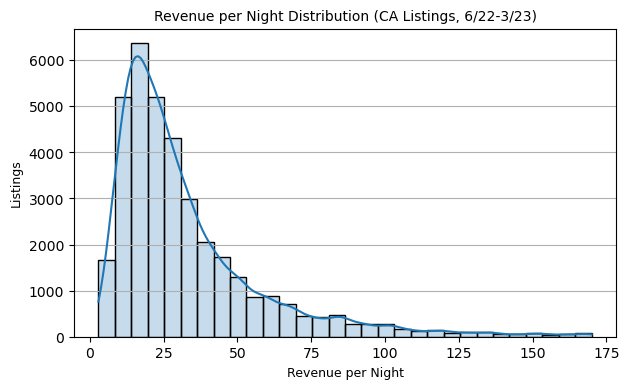

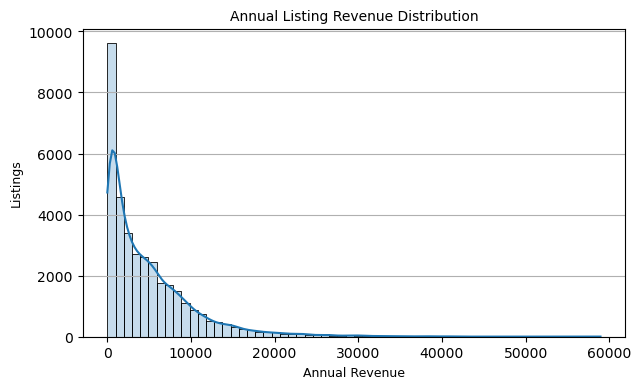

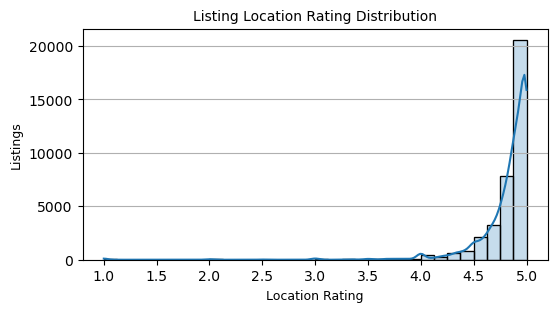

In [884]:
# distribution of revenue per night in CA
plt.figure(figsize=(7,4))
sns.histplot(cali_listings_df['revenue_nightly'], kde=True, bins=30, alpha=0.25)
plt.title('Revenue per Night Distribution (CA Listings, 6/22-3/23)', fontsize=10)
plt.xlabel('Revenue per Night', fontsize=9)
plt.ylabel('Listings', fontsize=9)
plt.grid(axis='y')

# boxplot - annual rev per listing in CA
plt.figure(figsize=(7,4))
sns.histplot(cali_listings_df['approx_revenue_yr'], kde=True, bins=60, alpha=0.25)
plt.title('Annual Listing Revenue Distribution', fontsize=10)
plt.xlabel('Annual Revenue', fontsize=9)
plt.ylabel('Listings', fontsize=9)
plt.grid(axis='y')

# distribution of location ratings
plt.figure(figsize=(6,3))
sns.histplot(cali_listings_df['loc_rating'], kde=True, bins=32, alpha=0.25)
plt.title('Listing Location Rating Distribution', fontsize=10)
plt.xlabel('Location Rating', fontsize=9)
plt.ylabel('Listings', fontsize=9)
plt.grid(axis='y')

- The distribution of revenue (per night and annually) from listings in CA is skewed right - upper outliers pull mean above median (mean revenue per night: \\$33.02, mean annual revenue: \\$4,993.48)
- Listings in CA get good location ratings, compared to the other rating categories - mean location rating is 4.81 (mean overall rating: 4.77, mean value rating: 4.72)

In [863]:
# get avg listing revenue per night and location ratings by city
city_avg_rev_loc_rate = cali_listings_df.groupby('city')[['loc_rating','revenue_nightly','approx_revenue_yr','overall_rating']].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
# revenue per night by city in CA
print('Top 20 Cities in CA by Avg Revenue per Night:', '\n\n', city_avg_rev_loc_rate[['city','revenue_nightly','loc_rating']].head(20))

Top 20 Cities in CA by Avg Revenue per Night: 

                       city  revenue_nightly  loc_rating
0         Del Monte Forest           129.76        4.97
1             Hillsborough            97.75        5.00
2        San Joaquin Hills            86.93        4.96
3             San Clemente            79.90        4.98
4              Rio Del Mar            77.23        4.93
5               Villa Park            73.57        4.93
6              Watsonville            73.51        4.93
7               Las Flores            71.03        4.92
8             Malibu Beach            66.53        4.95
9           La Selva Beach            66.48        4.92
10              Moss Beach            65.28        4.99
11           Newport Beach            64.52        4.89
12               Calabasas            63.58        4.91
13              Dana Point            62.15        4.87
14  Highlands-Baywood Park            60.93        4.80
15                Capitola            60.51        4.95

- Note: All of these cities have location ratings above the average (4.81), except Highlands-Baywood Park, which barely fell short at 4.8

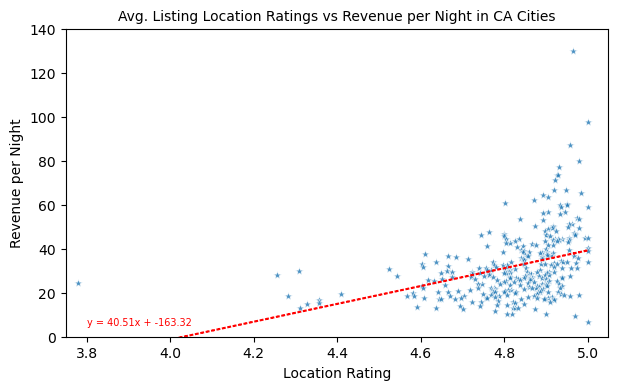

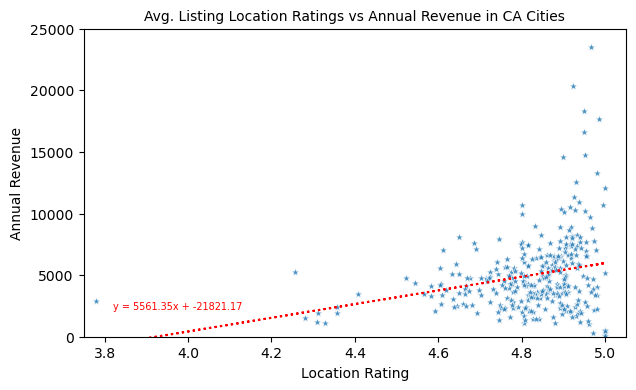

In [865]:
# loc rating vs revenue per night scatterplot
plt.figure(figsize=(7,4))
sns.scatterplot(x='loc_rating', y='revenue_nightly', data=city_avg_rev_loc_rate, alpha=0.8, marker='*')
plt.title('Avg. Listing Location Ratings vs Revenue per Night in CA Cities', fontsize=10)
plt.ylabel('Revenue per Night')
plt.xlabel('Location Rating')
plt.ylim(0,140)
plt.xlim(3.75,5.05)
# plot trendline and display equation
x = city_avg_rev_loc_rate['loc_rating']
y = city_avg_rev_loc_rate['revenue_nightly']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='red', linestyle=':')
equation = f"y = {z[0]:.2f}x + {z[1]:.2f}"
plt.text(3.8, 5, equation, fontsize=7, color="red")
plt.show()

# loc rating vs revenue per year scatterplot
plt.figure(figsize=(7,4))
sns.scatterplot(x='loc_rating', y='approx_revenue_yr', data=city_avg_rev_loc_rate, alpha=0.8, marker='*')
plt.title('Avg. Listing Location Ratings vs Annual Revenue in CA Cities', fontsize=10)
plt.ylabel('Annual Revenue')
plt.xlabel('Location Rating')
plt.ylim(0,25000)
plt.xlim(3.75,5.05)
# plot trendline and display equation
x = city_avg_rev_loc_rate['loc_rating']
y = city_avg_rev_loc_rate['approx_revenue_yr']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='red', linestyle=':')
equation = f"y = {z[0]:.2f}x + {z[1]:.2f}"
plt.text(3.82, 2200, equation, fontsize=7, color="red")
plt.show()

- <span style="color:green"><strong>Average location ratings have a positive linear relationship with both average revenue per night and year (trendline coefficient: 5,561.35)</span>
  - <span style="color:green"><strong>The coefficient of the trendline equation suggests that for every unit increase in location rating, revenue per night is \\$40.51 more (\\$5,561.35 for revenue annually)</span>

**Correlation - Location Ratings and Revenue per Night:**

<AxesSubplot:>

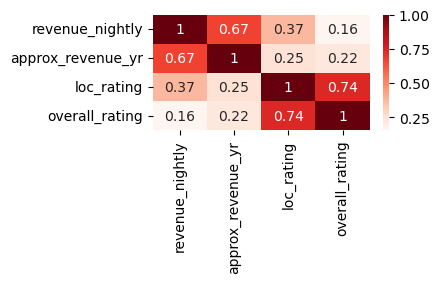

In [552]:
# correlation heatmap
plt.figure(figsize=(3.5,1.5))
sns.heatmap(city_avg_rev_loc_rate.corr(), annot=True, cmap='Reds')

- <span style="color:green"><strong>For CA cities, there is a moderate positive correlation between average listing revenue per night and their location ratings (corr coeff: 0.37)
  - There's a moderate positive correlation between average revenue annually and location ratings as well (corr coeff: 0.25)</span>


- <span style="color:green"><strong>Also, the correlations between revenue (per night and year) and location rating are stronger than with overall rating</span>

**Regression Model - Listing Revenue per Night and Location Ratings:**

In [1922]:
# define dep. variable (revenue) and indep. variable (rating)
y = city_avg_rev_loc_rate['revenue_nightly']
x = city_avg_rev_loc_rate['loc_rating']

# add constant term to indep variable
x = sm.add_constant(x)

# fit linear regression model
model = sm.ols(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        revenue_nightly   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     49.87
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           1.10e-11
Time:                        07:48:37   Log-Likelihood:                -1264.6
No. Observations:                 310   AIC:                             2533.
Df Residuals:                     308   BIC:                             2541.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -163.3156     27.683     -5.899      0.0

- <p style="color:green"><strong>While the relationship between location rating and revenue per night is statistically significant, it's not particularly strong</strong></p>

  - The model's R-squared value measures the proportion of variation in revenue that can be explained by location rating -- R-sq is 0.139, indicating that about 13.9% of the variability in revenue per night can be explained by location rating
  - F-stat tests the overall significance of the regression model (higher F means model's ind. var. explains the dep. var. significantly) -- F is 49.87, with a probability of 1.10e-11, indicating the model is statistically significant
  - The location rating coefficient of around 40.5 represents the expected change in revenue per night for each unit increase in location rating (also statistically significant)

<a name="types"></a>
<h3> <p style="color:blue"><strong>2) Listing Types and Property Quality:</strong></p> </h3>

- Based on listings in California...
  - Which listing property / room types are most valuable?
  - How much do property related ratings impact revenue (cleanliness, value, and accuracy)?
  - Which amenities are associated with more income from a listing?

<a name="type"></a>
<p style="color:orange"><strong>2a - Room and Property Types:</strong></p>

- Which listing room / property types are most valuable for Airbnb?

<p style="color:orange"><strong>Room Types:</strong></p>

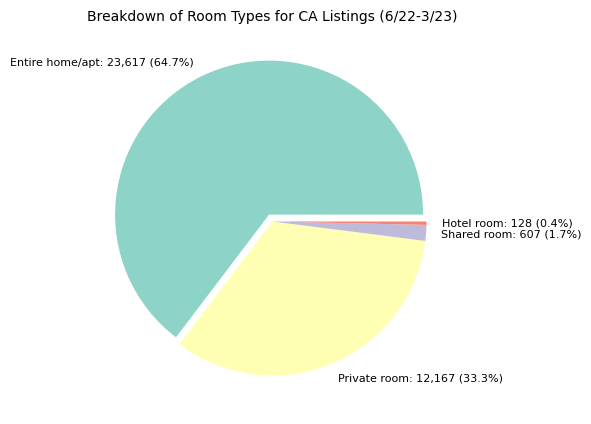

In [869]:
# Calculate the listing count for each room type
room_type_counts = cali_listings_df['room_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie(room_type_counts,labels=[f'{room_type}: {count:,} ({count/sum(room_type_counts)*100:.1f}%)' for room_type, count in room_type_counts.items()], 
        colors=plt.cm.Set3.colors, explode = (0.05, 0, 0, 0),textprops={'fontsize': 8})
plt.title('Breakdown of Room Types for CA Listings (6/22-3/23)', fontsize=10)
#plt.legend(room_type_counts.index, loc='upper right', fontsize=8)
plt.show()

- The most common listing room type in CA were entire homes / apartments (23,617 listings), then private rooms (12,167), shared rooms (607), and hotel rooms (128)
  - There were much fewer shared room and hotel room listings -- clearly, entire home/apts and private rooms are much more popular for hosts to put on the platform

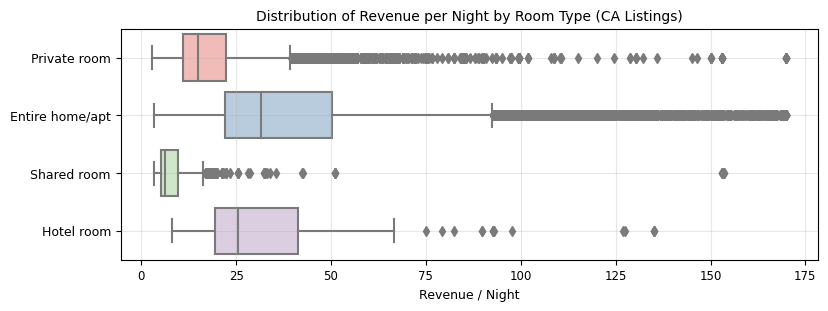

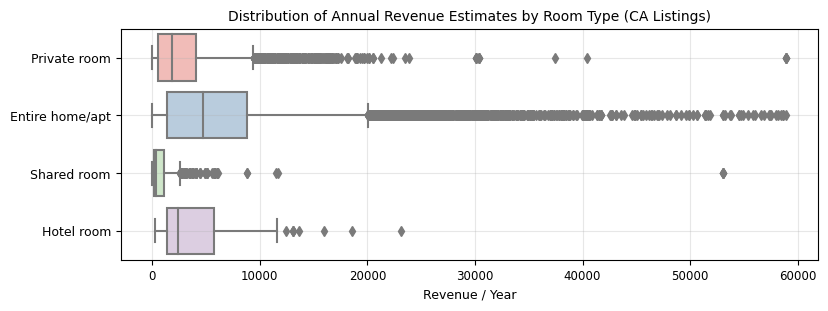

Avg. Listing Revenue per Night by Room Type: 
 room_type
Entire home/apt   40.62
Hotel room        37.69
Private room      19.33
Shared room       10.92
Name: revenue_nightly, dtype: float64 


Avg. Listing Revenue Annually by Room Type: 
 room_type
Entire home/apt   6263.64
Hotel room        4005.23
Private room      2723.28
Shared room       1287.71
Name: approx_revenue_yr, dtype: float64


In [867]:
# boxplot - distribution of revenue per night by room type
plt.figure(figsize=(9,3))
sns.boxplot(y='room_type', x='revenue_nightly', data=cali_listings_df, palette='Pastel1', orient='h')
plt.title('Distribution of Revenue per Night by Room Type (CA Listings)', fontsize=10)
plt.ylabel('')
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=9)
plt.xlabel('Revenue / Night', fontsize=9)
plt.grid(alpha=0.3)
plt.show()

# boxplot - distribution of annual revenue by room type
plt.figure(figsize=(9,3))
sns.boxplot(y='room_type', x='approx_revenue_yr', data=cali_listings_df, palette='Pastel1', orient='h')
plt.title('Distribution of Annual Revenue Estimates by Room Type (CA Listings)', fontsize=10)
plt.ylabel('')
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=9)
plt.xlabel('Revenue / Year', fontsize=9)
plt.grid(alpha=0.3)
plt.show()

# CA listings room type avg revenue per night / year
room_type_rev_night = cali_listings_df.groupby(['room_type'])['revenue_nightly'].mean().sort_values(ascending=False)
print('Avg. Listing Revenue per Night by Room Type:', '\n',  room_type_rev_night, '\n\n')
room_type_rev_yr = cali_listings_df.groupby('room_type')['approx_revenue_yr'].mean().sort_values(ascending=False)
print('Avg. Listing Revenue Annually by Room Type:', '\n',  room_type_rev_yr)

- <p style="color:green"><strong>Entire homes / apartments had the highest mean and median listing revenue per night of all room types, followed by hotel rooms, private rooms, and shared rooms</strong></p>
  
    - <p style="color:green"><strong>Entire home/apt listings also made much more revenue annually, on average, than the other room types</strong></p>

**Kruskal-Wallis Test:**

- Do the distributions of annual revenue for room types differ significantly?
  - Using Kruskal-Wallis Test instead of ANOVA, because the revenue data isn't normally distributed
- The Dunn test post hoc comparisons allow for insight on the specific differences between room types

In [271]:
# Kruskal-Wallis test
rooms = cali_listings_df['room_type'].unique()
grouped_rev = [cali_listings_df[cali_listings_df['room_type'] == room]['approx_revenue_yr'] for room in rooms]
kruskal_test = kruskal(*grouped_rev)
print('Kruskal-Wallis Test Result:','\n','H-statistic:',kruskal_test.statistic,'\n','p-value:', kruskal_test.pvalue,'\n')

# Dunn post hoc comparisons test
dunn_test = posthoc_dunn(cali_listings_df, val_col='approx_revenue_yr', group_col='room_type')
print("Dunn's Test Post Hoc Comparisons (p-values):",'\n',dunn_test)

Kruskal-Wallis Test Result: 
 H-statistic: 4063.5765003521756 
 p-value: 0.0 

Dunn's Test Post Hoc Comparisons (p-values): 
                  Entire home/apt  Hotel room  Private room  Shared room
Entire home/apt             1.00        0.00          0.00         0.00
Hotel room                  0.00        1.00          0.00         0.00
Private room                0.00        0.00          1.00         0.00
Shared room                 0.00        0.00          0.00         1.00


- <p style="color:green"><strong>The room type of a listing has a notable impact on its annual revenue</strong></p>

  - The large H-statistic (4063.58) indicates the ranked data for annual revenue vary significantly across room types
  - The low p-value (0) gives strong evidence to reject the null hypothesis -- so, there are significant differences in the annual revenue distributions between room types (unlikely to be due to random chance)

- <p style="color:green"><strong>Also, the p-values of 0 for room type pair comparisons reveal there are significant differences in annual revenue between all pairs of room types</strong></p>

<p style="color:orange"><strong>Property Types:</strong></p>

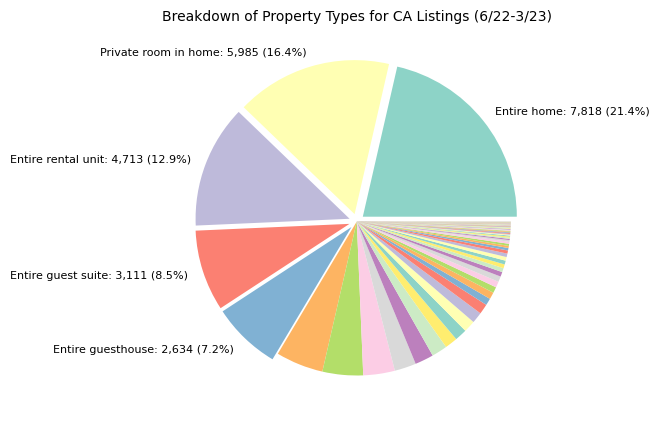

In [870]:
# Calculate the listing count for each property type
property_type_counts = cali_listings_df['property_type'].value_counts()

# Select the top 5 property types by count
top_property_types = property_type_counts.head(5)

# Create a pie chart with custom labels for the top 5 property types
plt.figure(figsize=(5,5))
plt.pie(
    property_type_counts,
    labels=[f'{property_type}: {count:,} ({count/sum(property_type_counts)*100:.1f}%)' if property_type in top_property_types.index else None for property_type, count in property_type_counts.items()], 
    colors=plt.cm.Set3.colors, 
    explode=[0.05 if property_type in top_property_types.index else 0 for property_type in property_type_counts.index],
    textprops={'fontsize': 8}
)
plt.title('Breakdown of Property Types for CA Listings (6/22-3/23)', fontsize=10)
plt.show()

- The five most common listing property types were entire homes, then private rooms in homes, entire rental units, entire guest suites, and entire guesthouses
  - There are many more listing property types than room types

In [798]:
# avg revenue grouped by property / room type (all types)
prop_type_avg_rev = cali_listings_df.groupby(['property_type','room_type'])[['revenue_nightly','approx_revenue_yr']].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
prop_type_avg_rev.head()

,property_type,room_type,revenue_nightly,approx_revenue_yr
0,Room in hotel,Entire home/apt,97.50,202.11
1,Entire villa,Entire home/apt,87.60,12171.11
2,Room in resort,Hotel room,78.55,1789.68
3,Entire chalet,Entire home/apt,72.04,1619.13
4,Entire resort,Entire home/apt,69.25,613.99


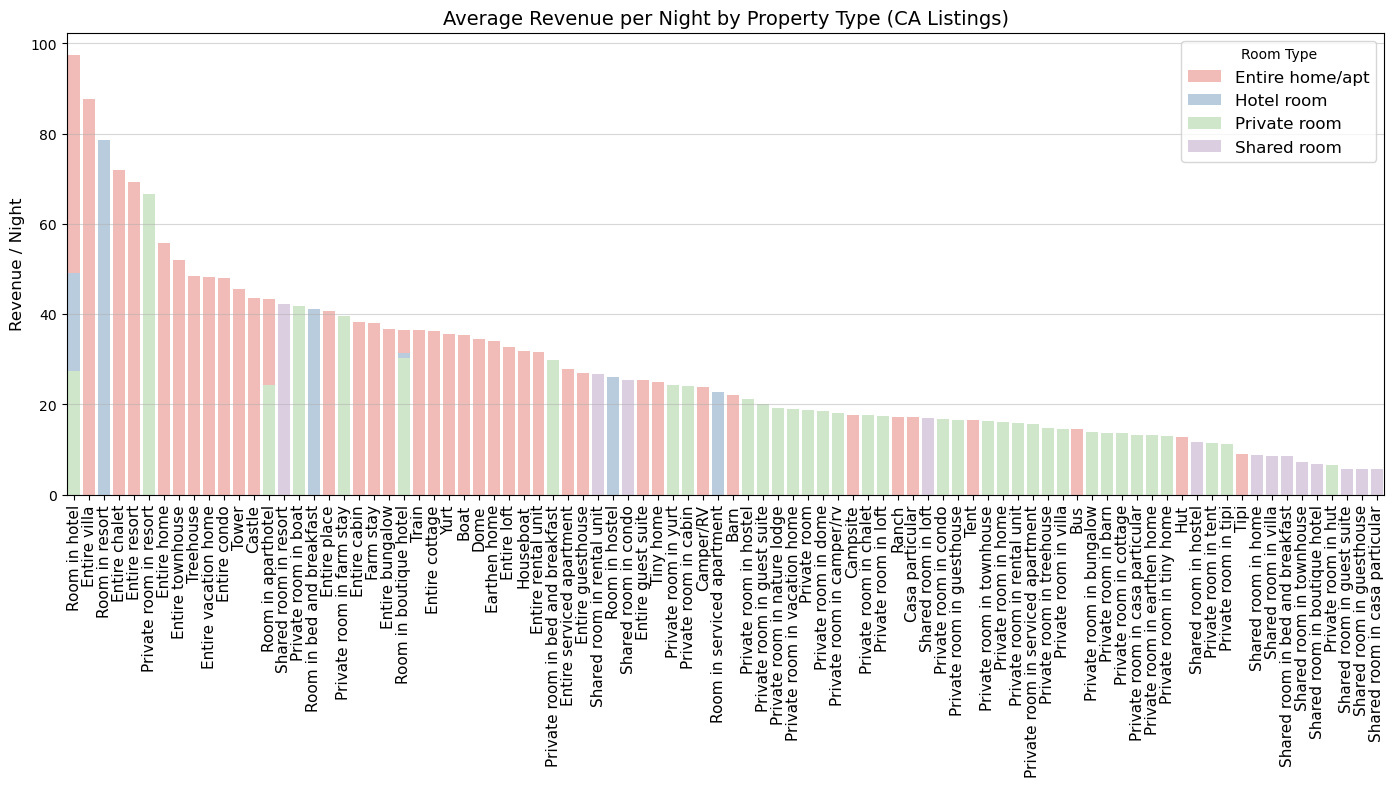

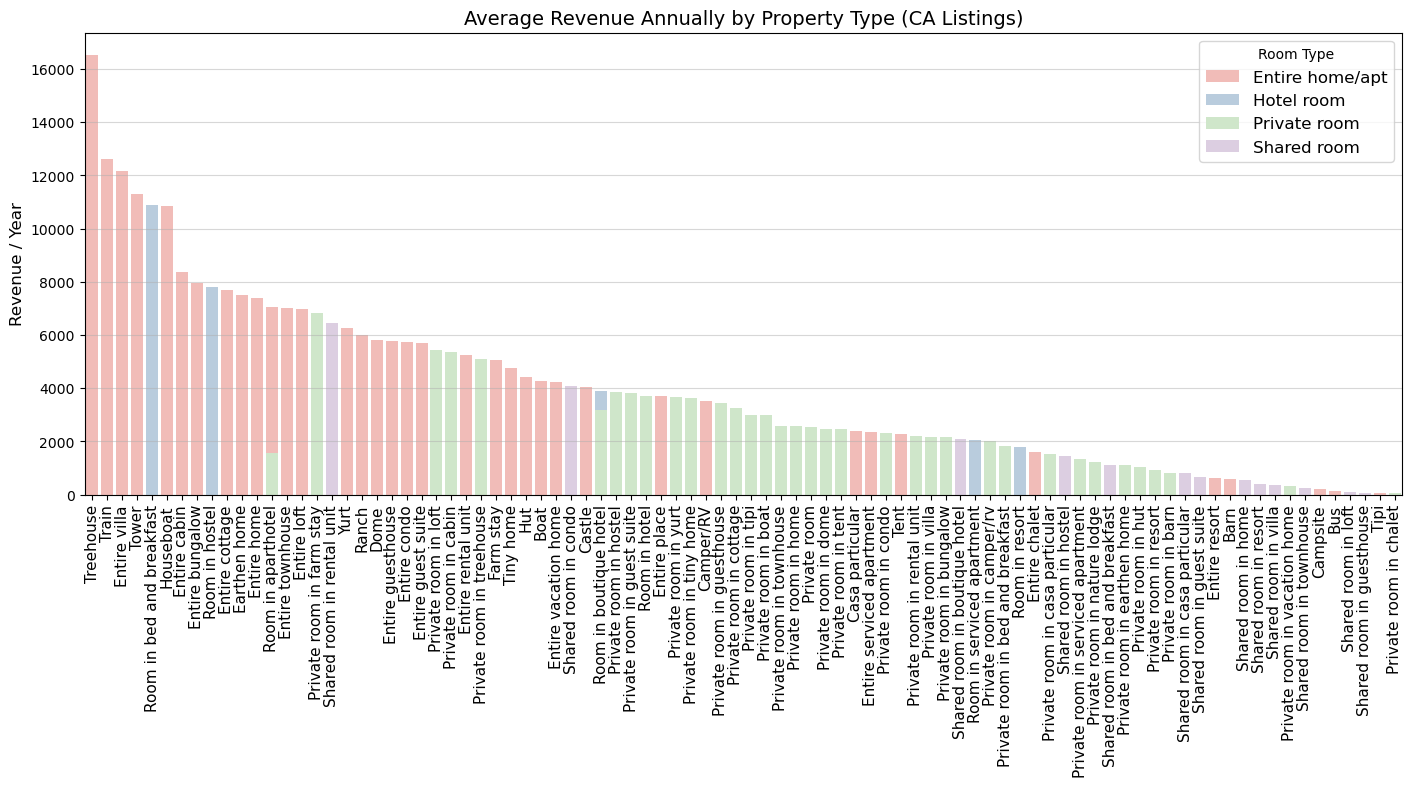

In [811]:
# barplot - avg rev per night by prop type
plt.figure(figsize=(17,6)) 
sns.barplot(x='property_type', y='revenue_nightly', data=prop_type_avg_rev, 
            hue='room_type',dodge=False, palette=sns.color_palette('Pastel1', n_colors=4, desat=1))
plt.title('Average Revenue per Night by Property Type (CA Listings)', fontsize=14)
plt.xlabel('')
plt.ylabel('Revenue / Night', fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.legend(title='Room Type', loc='upper right', fontsize='large')
plt.grid(axis='y', alpha=0.5)
plt.show()
print('\n')


# barplot - avg rev per year by prop type
plt.figure(figsize=(17,6))
sns.barplot(x='property_type', y='approx_revenue_yr', 
            data=prop_type_avg_rev.sort_values(by='approx_revenue_yr',ascending=False), 
            hue='room_type',dodge=False, palette=sns.color_palette('Pastel1', n_colors=4, desat=1))
plt.title('Average Revenue Annually by Property Type (CA Listings)', fontsize=14)
plt.xlabel('')
plt.ylabel('Revenue / Year', fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.legend(title='Room Type', loc='upper right', fontsize='large')
plt.grid(axis='y', alpha=0.5)
plt.show()

- As shown by the bar colors, a large majority of the top earning (per night & year) property types are entire home/apt listings
  - Properties with hotel and private rooms also do fairly well, while most property types with shared rooms are at the bottom end
- Many of the top earning property types also seem to be very unique, like treehouse, tower, train, castle, dome, yurt, tiny home, farm stay, etc. 


- *Side Note*: For most property types, Airbnb's service fee is split between the guest and host, totalling ~17% of the booking total (Abnb revenue)
  - However, for traditional hospitality listings, like hotels, only the host is charged the service fee, ~15% of the booking total

**Further Review of Most Common Property Types:**

- There's a limited number of very unique properties -- need to investigate the top five most common listing property types as they accounted for about two thirds of all listings in CA between 6/22 and 3/23

In [ ]:
# property types to keep
prop_types_to_keep = ['Entire home','Private room in home','Entire rental unit','Entire guest suite','Entire guesthouse']

# filter cali_listings_df for 5 most commonly listed property types
prop_type_top = cali_listings_df[cali_listings_df['property_type'].isin(prop_types_to_keep)].sort_values(by='revenue_nightly', ascending=False).reset_index()
prop_type_top.head()

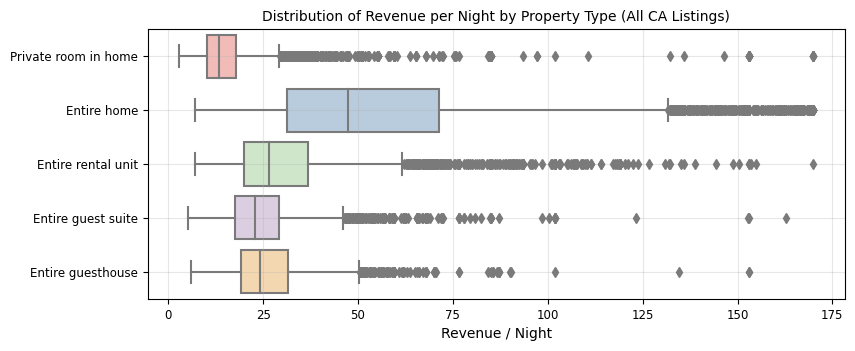

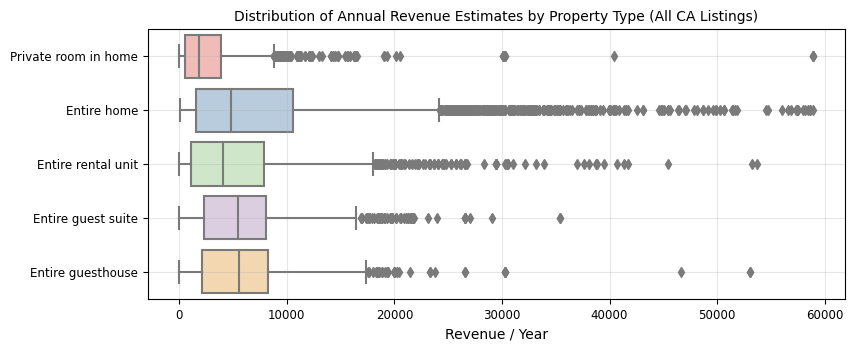

Avg. Annual Revenue by Listing Property Type: 
 property_type
Entire home            7385.33
Entire guesthouse      5786.76
Entire guest suite     5699.54
Entire rental unit     5263.59
Private room in home   2565.86
Name: approx_revenue_yr, dtype: float64 


Avg. Revenue per Night by Listing Property Type: 
 property_type
Entire home            55.71
Entire rental unit     31.50
Entire guesthouse      26.92
Entire guest suite     25.35
Private room in home   16.11
Name: revenue_nightly, dtype: float64


In [873]:
# boxplot - distribution of revenue per night by property type
plt.figure(figsize=(9,3.5))
sns.boxplot(y='property_type', x='revenue_nightly', data=prop_type_top, palette='Pastel1', orient='h')
plt.title('Distribution of Revenue per Night by Property Type (All CA Listings)', fontsize=10)
plt.xlabel('Revenue / Night', fontsize=10)
plt.ylabel('')
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.grid(alpha=0.3)
plt.show()

# boxplot - distribution of revenue annually by property type
plt.figure(figsize=(9,3.5))
sns.boxplot(y='property_type', x='approx_revenue_yr', data=prop_type_top, palette='Pastel1', orient='h')
plt.title('Distribution of Annual Revenue Estimates by Property Type (All CA Listings)', fontsize=10)
plt.xlabel('Revenue / Year', fontsize=10)
plt.ylabel('')
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.grid(alpha=0.3)
plt.show()

# most common property types, avg annual revenue per listing
prop_type_rev_yr = prop_type_top.groupby('property_type')['approx_revenue_yr'].mean().sort_values(ascending=False)
print('Avg. Annual Revenue by Listing Property Type:', '\n',  prop_type_rev_yr, '\n\n')
# most common property types, avg revenue per night
prop_type_rev_night = prop_type_top.groupby('property_type')['revenue_nightly'].mean().sort_values(ascending=False)
print('Avg. Revenue per Night by Listing Property Type:', '\n',  prop_type_rev_night)

- <p style="color:green"><strong>Of the five most frequently listed property types, entire homes had the top average revenue per night and year (also had highest median revenue per night)</strong></p>
  - However, entire guest suites / guesthouses had a slightly higher median average annual revenue (more upper annual revenue outliers for entire homes, which make the mean higher, but not median)

- <p style="color:green"><strong>Overall, entire room / property type listings were the most common and generated the most revenue of all room / property types in California</strong></p>
  - Privacy is clearly a top priority for guests


- <p style="color:green"><strong>Also, guests tend to pay higher prices for unique property listings - there just aren't that many of them compared to more traditional ones</strong></p>

<a name="proprating"></a>
<p style="color:orange"><strong>2b - Property-Related Ratings:</strong></p>

- How do a listing's property related ratings (cleanliness, value, and accuracy) impact revenue?

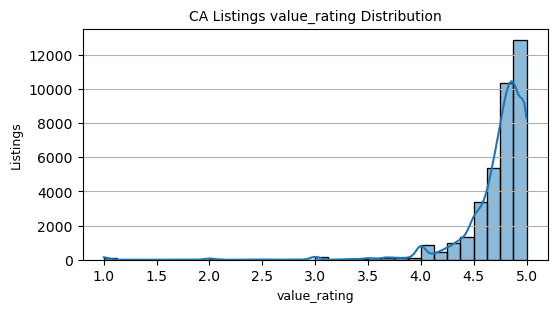

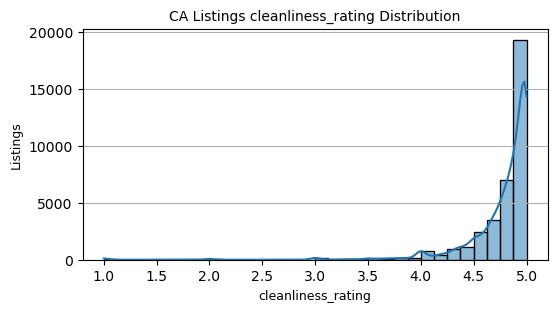

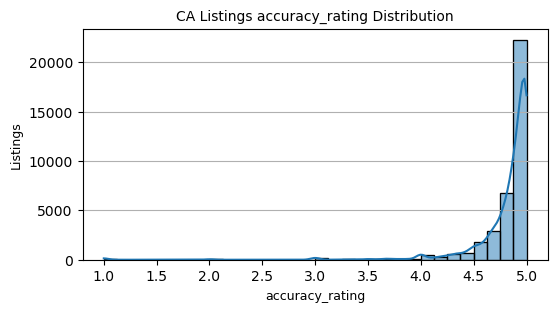

In [285]:
# distribution of ratings
ratings = cali_listings_df[['value_rating', 'cleanliness_rating', 'accuracy_rating']]

for column in ratings.columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=ratings, x=column, kde=True, bins=32, alpha=0.5)
    plt.title(f'CA Listings {column} Distribution', fontsize=10)
    plt.xlabel(column, fontsize=9)
    plt.ylabel('Listings', fontsize=9)
    plt.grid(axis='y')
    plt.show()

In [286]:
# get avg revenue and ratings by listing
avg_rev_prop_rates = cali_listings_df.groupby('listing_id')[['revenue_nightly','approx_revenue_yr','value_rating','cleanliness_rating',
                                                             'accuracy_rating','overall_rating']].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
avg_rev_prop_rates.describe()

,listing_id,revenue_nightly,approx_revenue_yr,value_rating,cleanliness_rating,accuracy_rating,overall_rating
count,13448.00,13448.00,13448.00,13448.00,13448.00,13448.00,13448.00
mean,177958070814482528.00,33.58,4669.25,4.72,4.76,4.80,4.76
std,298385830080876864.00,26.78,5815.94,0.40,0.40,0.39,0.40
min,2732.00,3.40,8.97,1.00,1.00,1.00,1.00
25%,24375785.75,15.90,714.29,4.66,4.71,4.78,4.71
50%,44955871.00,25.41,2682.76,4.82,4.89,4.92,4.88
75%,561492228770545600.00,41.82,6555.69,4.93,4.99,5.00,4.98
max,844425825212996352.00,170.00,58947.50,5.00,5.00,5.00,5.00


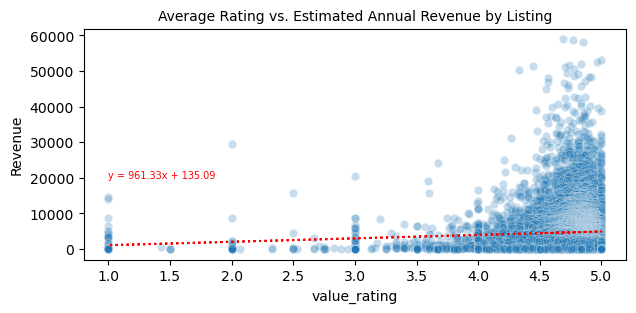

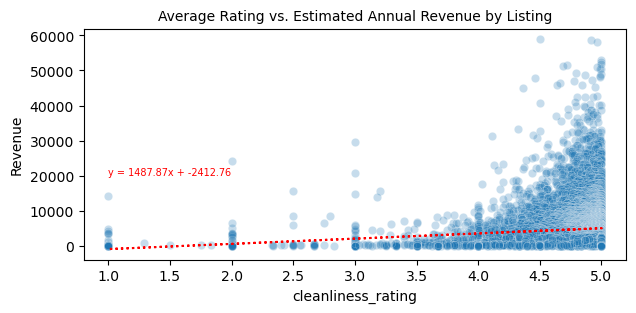

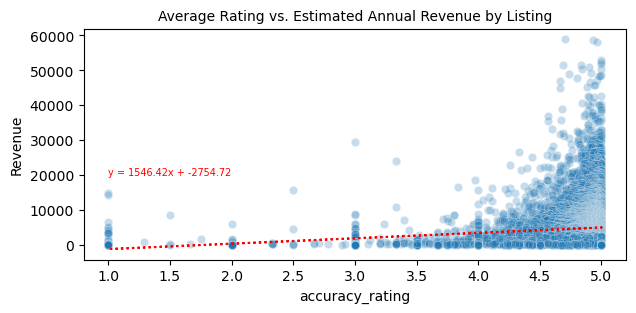

In [290]:
ratings = ['value_rating', 'cleanliness_rating', 'accuracy_rating']

for rating in ratings:
    plt.figure(figsize=(7,3))
    sns.scatterplot(x=rating, y='approx_revenue_yr', data=avg_rev_prop_rates, alpha=0.25)
    plt.title('Average Rating vs. Estimated Annual Revenue by Listing', fontsize=10)
    plt.ylabel('Revenue')
    plt.xlabel(rating)
    x = avg_rev_prop_rates[rating]
    y = avg_rev_prop_rates['approx_revenue_yr']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='red', linestyle=':')
    equation = f'y = {z[0]:.2f}x + {z[1]:.2f}'
    plt.text(1, 20000, equation, fontsize=7, color='red')
    plt.show()

- Based on the trendlines and their equations on the plots above, there doesn't seem to be much of a meaningful relationship between any of the ratings and annual revenue

**Correlation - Average Property Rating and Revenue:**

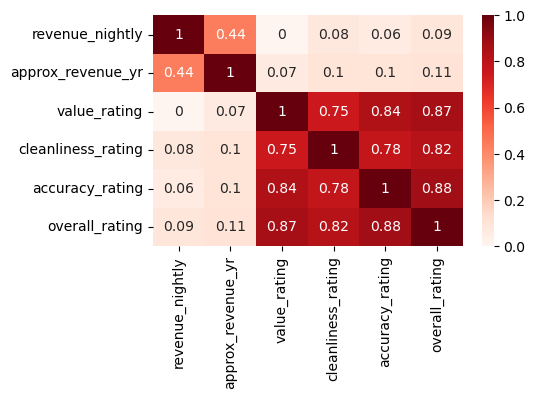

In [890]:
# correlations between property related ratings and revenues
cols = ['revenue_nightly','approx_revenue_yr','value_rating','cleanliness_rating','accuracy_rating','overall_rating']
prop_rate_corr = round(avg_rev_prop_rates[cols].corr(), 2)
# correlation matrix heatmap
plt.figure(figsize=(5,3))
sns.heatmap(prop_rate_corr, annot=True, cmap='Reds')
plt.show()

- <p style="color:green"><strong>Surprisingly, there are no significant relationships between average property-related ratings (value, cleanliness, and accuracy) and average revenue per night or year (only very weak positive correlations)</strong></p>

<a name="amenities"></a>
<p style="color:orange"><strong>2c - Listing Amenities:</strong></p>

- Which amenities are included in high value listings?
- Using smaller sample, listings in San Diego, to be able to work with amenities data (SD has the most unique listings in CA, of the cities included)

In [11]:
# top cities by listing count in CA
city_list_cnt = cali_listings_df.groupby('city')['listing_id'].nunique().sort_values(ascending=False).reset_index()
print('Top 5 cities by count of unique listings:\n', city_list_cnt.head(5))

Top 5 cities by count of unique listings:
             city  listing_id
0      San Diego        1281
1  San Francisco        1247
2       La Jolla         690
3      Daly City         407
4       Coronado         286


**Create / Transform DF for Analysis of Amenities:**

In [17]:
# dataframe for listings in San Diego
sd_listings = cali_listings_df[cali_listings_df['city'] == 'San Diego']

# columns to keep
desired_columns = ['listing_id', 'amenities', 'revenue_nightly', 'approx_revenue_yr']

# Filter the dataframe for the desired columns
sd_listings = sd_listings[desired_columns]

sd_listings.head()

,listing_id,amenities,revenue_nightly,approx_revenue_yr
1066207,616072157341597081,"[""Paid parking on premises"", ""Wifi"", ""Dishes a...",24.00,4182.19
1066136,611955248322854679,"[""Wifi"", ""Body soap"", ""Refrigerator"", ""Dedicat...",21.25,99.65
1066037,598522027613565545,"[""Dishwasher"", ""Ceiling fan"", ""Wifi"", ""Dishes ...",9.52,46.14
1066066,608222403578012662,"[""Wifi"", ""Dishes and silverware"", ""Trash compa...",22.44,466.75
1066074,608680157676051588,"[""Ceiling fan"", ""Wifi"", ""Luggage dropoff allow...",14.62,5069.49


In [18]:
# convert amenities column to list type (to be able to explode column)
sd_listings['amenities'] = sd_listings['amenities'].apply(ast.literal_eval)

In [19]:
# explode amenities column
sd_listings = sd_listings.explode('amenities')
sd_listings.head()

,listing_id,amenities,revenue_nightly,approx_revenue_yr
1066207,616072157341597081,Paid parking on premises,24.00,4182.19
1066207,616072157341597081,Wifi,24.00,4182.19
1066207,616072157341597081,Dishes and silverware,24.00,4182.19
1066207,616072157341597081,Laundromat nearby,24.00,4182.19
1066207,616072157341597081,Room-darkening shades,24.00,4182.19


In [22]:
# finish transforming sd_listings dataframe to work with going forward

# create columns for each type of amenity, with values of 1 or 0 for each row, depending on whether the listing has it
# then, group by listing with avg revenues and amenities columns indicating if listing has the amenity

# unique amenities
amenities = sd_listings['amenities'].unique()

# create list of the new columns for each amenity
new_columns = []
for amenity in amenities:
    new_column = sd_listings['amenities'].apply(lambda x: 1 if x == amenity else 0)
    new_column.name = amenity
    new_columns.append(new_column)

# concatenate original dataframe with the new columns
sd_listings = pd.concat([sd_listings] + new_columns, axis=1)

# drop original amenities column
sd_listings = sd_listings.drop('amenities', axis=1)

# group by listing id and aggregate revenue / amenities columns
sd_listings = sd_listings.groupby('listing_id').agg({'revenue_nightly':'mean',
                                                     'approx_revenue_yr':'mean',
                                                     **{amenity:'max' for amenity in amenities}}).reset_index()

**Amenities Count and Average Revenue:**

In [20]:
# make copy of sd_listings after exploding for analysis by amenity
sd_list_amenities_expl = sd_listings.copy()

In [21]:
# save san diego amenities dataframes to csv
sd_list_amenities_expl.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/sd_amenities_explode_df.csv')
sd_listings.to_csv('C:/Users/lukeg/OneDrive/Documents/Airbnb Project/abnb_data_files/sd_list_amenities_df.csv')

In [30]:
# most common amenities
amenity_counts = sd_list_amenities_expl['amenities'].value_counts().sort_values(ascending=False)
print('Most Common Amenities (Mainly Essentials):','\n\n',amenity_counts.head(15))

Most Common Amenities (Mainly Essentials): 

 Smoke alarm              3619
Essentials               3520
Carbon monoxide alarm    3396
Hair dryer               3288
Wifi                     3282
Hot water                3269
Iron                     3175
Hangers                  3174
Microwave                3003
Shampoo                  2940
Dishes and silverware    2927
Fire extinguisher        2879
Kitchen                  2872
Bed linens               2785
Refrigerator             2730
Name: amenities, dtype: int64


In [ ]:
# avg listing revenue per night / year by amenity
amenity_avg_rev = sd_list_amenities_expl.groupby('amenities')['revenue_nightly'].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
print('Top 20 Amenities by Avg. Revenue per Night:\n\n', amenity_avg_rev.head(20))

- HDTVs are included in most of the top earning listings

**High Value Listing Amenities:**

In [ ]:
sd_top_list_rev_yr = sd_listings.sort_values(by='revenue_nightly', ascending=False).head(10)
sd_top_list_rev_yr.head()

In [172]:
# calculate sum of each amenity column for top 10 listings - counts listings each amenity is in of top 10 listings
# drop amenities that are either not in any or are in more than 5 of the 10 listings - removes common / essential amenities
top_list_amen_cnt = sd_top_list_rev_yr.drop(['listing_id', 'revenue_nightly', 'approx_revenue_yr'], axis=1).sum().sort_values(ascending=False)
top_list_amen_cnt = top_list_amen_cnt[(top_list_amen_cnt > 0) & (top_list_amen_cnt < 6)]
top_list_amen_cnt

Long term stays allowed            5
Self check-in                      5
Smart lock                         5
Private backyard – Fully fenced    5
Pets allowed                       4
                                  ..
Mountain view                      1
Standalone high chair              1
Hot water kettle                   1
Smoking allowed                    1
Drying rack for clothing           1
Length: 88, dtype: int64

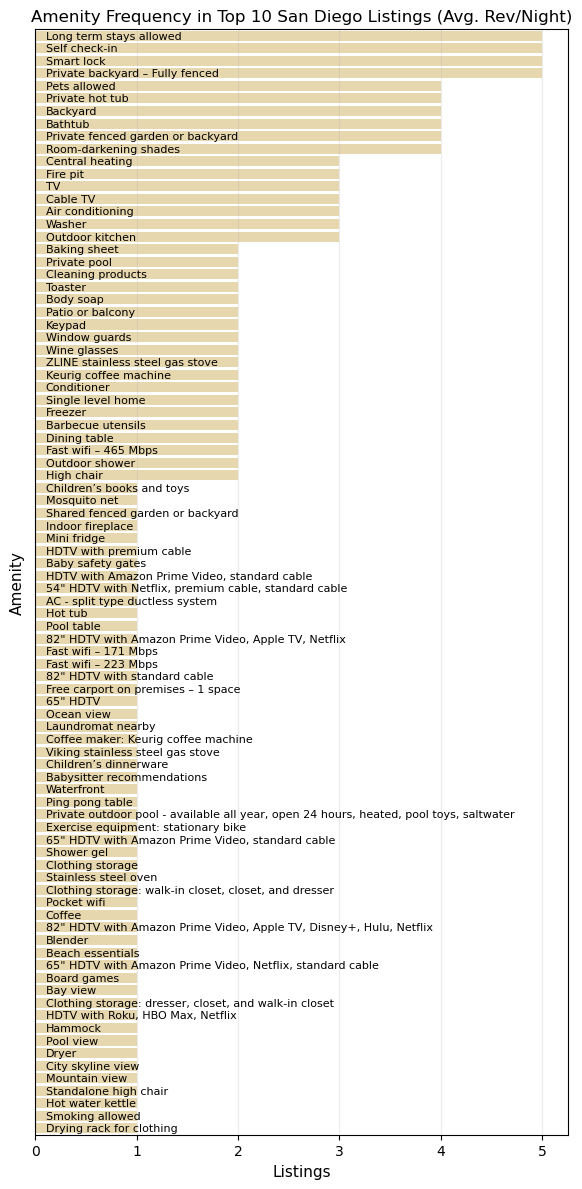

In [194]:
# bar plot showing amenity counts
plt.figure(figsize=(6,12))
ax = sns.barplot(x=top_list_amen_cnt.values, y=top_list_amen_cnt.index, color='goldenrod', alpha=0.4)
plt.title('Amenity Frequency in Top 10 San Diego Listings (Avg. Rev/Night)', fontsize=12)
plt.xlabel('Listings', fontsize=11)
plt.ylabel('Amenity', fontsize=11)
plt.yticks([])
plt.grid(alpha=0.25)
# put amenity labels on bars
for ind, amenity_name in enumerate(top_list_amen_cnt.index):
    ax.text(0.1, ind, amenity_name, va='center', ha='left', fontsize=8)
plt.tight_layout()
plt.show()

- The plot above shows the number of listings (of the top 10 by avg revenue per night in San Diego) include these amenities
  - The number of listings an amenity is included in has been limited to 5 listings, so that more unique / non-essential aren't shown
- When looking at the chart, can see several of these listings have good views, large HDTVs, strong wifi, child/family accommodations, access to a pool/ocean/hot tub, backyards, activities (ping pong, pool table, fire pit, exercise bike), etc.
  - Also, several of the amenities included have a focus on privacy (self check-in, smart lock, private backyard/hot tub/pool)
  - Four of the ten listings allow pets

**Correlations - Listing Amenities and Revenue:**

In [2294]:
# get corr matrix for avg annual revenue
corr_matrix = sd_listings.corr()
corr_matrix = corr_matrix.loc['approx_revenue_yr', :]
# filter correlation matrix for abs value > 0.15
corr_matrix = corr_matrix[abs(corr_matrix) > 0.15].dropna(how='any', axis=0).sort_values(ascending=False)
print('Listing Amenity Correlations with Avg. Revenue Annually:', '\n', corr_matrix, '\n\n')

# get correlation matrix for avg revenue per night
corr_matrix = sd_listings.corr()
corr_matrix = corr_matrix.loc['revenue_nightly', :]
# filter corr matrix by abs value > 0.15 / drop null rows
corr_matrix = corr_matrix[abs(corr_matrix) > 0.15].dropna(how='any', axis=0).sort_values(ascending=False)
print('Listing Amenity Correlations with Avg. Revenue per Night:', '\n', corr_matrix)

Listing Amenity Correlations with Avg. Revenue Annually: 
 approx_revenue_yr                                                                         1.00
revenue_nightly                                                                           0.37
Pack ’n play/Travel crib                                                                  0.34
High chair                                                                                0.30
Crib                                                                                      0.29
Private outdoor pool - available all year, open 24 hours, heated, pool toys, saltwater    0.27
Coffee maker                                                                              0.26
Smart lock                                                                                0.22
65" HDTV with Amazon Prime Video, standard cable                                          0.21
HDTV with Amazon Prime Video, standard cable                                          

Correlations between avg revenue annually and listing amenities:
 - Amenities that accommodate families with kids (high chair, travel crib, crib, children's books/toys) have a moderately strong positive relationship with annual revenue from listings
 - Some other interesting amenities that have positive correlations with annual revenue are private pool, smart lock, self check-in, private entrance, private patio / balcony, lock on bedroom door  - guests value privacy
 - HDTVs and free parking also have positive relationships with annual revenue
 - Aside from these, most of the amenities with notable correlations to annual revenue seem to be fairly basic / essential


Correlations between avg revenue per night and listing amenities:
 - Free washers and dryers have a moderate positive relationship with avg revenue per night
 - Again, family accommodating amenities like cribs, high chairs, and children's dinnerware have a positive relationship
 - More luxurious amenities like a private hot tub, private patio / balcony, outdoor kitchen, and ocean / bay view
 - Amenities with a focus on privacy and parking 

<p style="color:green"><strong>In summary...</strong></p>
  
- As expected, listings with luxurious amenities bring in a lot of revenue for Airbnb (i.e. pools, hot tubs, nice views, backyards, patios/balconies, etc.)

- However, some more unexpected amenity categories also had a positive relationship with listing revenue, like: 
  - Amenities that improve the guests' privacy
  - Amenities that accommodate children/families (also, 4/10 top listings in San Diego by avg revenue allowed pets)
  - Free amenities that would cost money otherwise (parking, washer/dryer)
  

- <p style="color:green"><strong>Other than the obviously valuable amenities (pools, hot tubs, views, etc.), privacy and child/family accommodations are two amenity categories that guests are willing to pay more for</strong></p>

<a name="engagement"></a>
<h3> <p style="color:blue"><strong>3) Host Engagement:</strong></p> </h3>

- Based on data from California, does the host's level of engagement help determine revenue from their listing(s)? 
  - Active listing counts
  - Superhost status
  - Host-related ratings (communications & check-in)

<a name="active"></a>
<p style="color:orange"><strong>3a - Total Active Listings:</strong></p>


- Does the number of total active listings for a host have any relationship with revenue from their listings? 
  - Also explore revenue from hosts with one vs. multiple active listings

In [298]:
# select columns to aggregate in dataframe, grouped by host_id and listing_id, sorted descending by total active listings
cols = ['revenue_nightly','approx_revenue_yr','host_total_list_cnt','host_entire_home_cnt',
        'host_private_room_cnt','host_shared_room_cnt']
ca_host_active_listings = cali_listings_df.groupby(['host_id', 'listing_id'])[cols].mean().sort_values(by='host_total_list_cnt', ascending=False).reset_index()
ca_host_active_listings.head()

,host_id,listing_id,revenue_nightly,approx_revenue_yr,host_total_list_cnt,host_entire_home_cnt,host_private_room_cnt,host_shared_room_cnt
0,271118401,37104238,79.90,4030.06,119.00,119.00,0.00,0.00
1,271118401,37104337,84.32,3405.58,119.00,119.00,0.00,0.00
2,271118401,37103516,122.06,2634.84,118.00,118.00,0.00,0.00
3,271118401,37104158,41.65,816.03,118.00,118.00,0.00,0.00
4,271118401,37104260,37.34,3274.55,115.67,115.67,0.00,0.00


In [ ]:
ca_host_active_listings.describe()

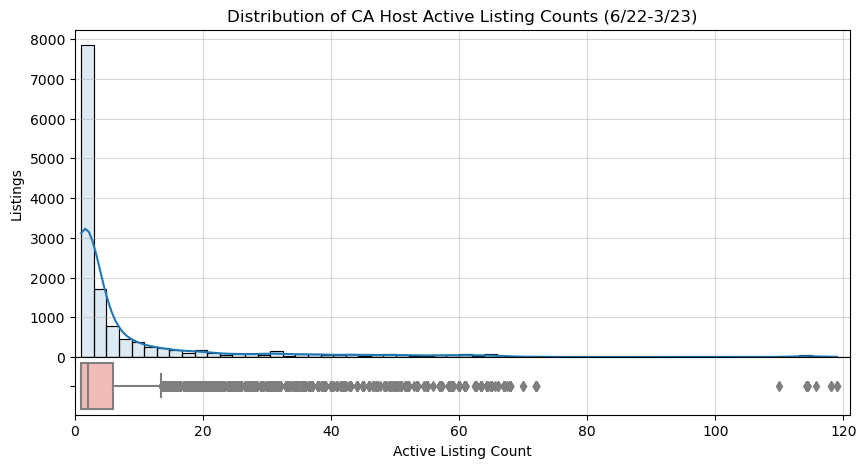

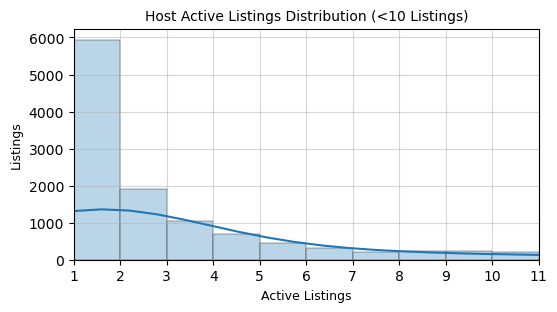

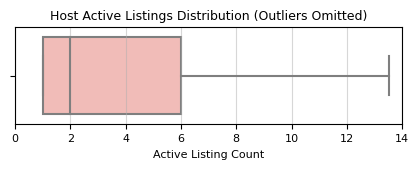

Share of listings from hosts with only 1 active listing:  41.5%


In [301]:
# create figure with two matplotlib.axes objects (ax_box and ax_hist)
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)}, figsize=(10,5))
# boxplot of host active listings
sns.boxplot(x='host_total_list_cnt', data=ca_host_active_listings, orient='h', palette='Pastel1', ax=ax_box)
ax_box.grid(axis='x', alpha=0.5)
ax_box.set_xlabel('Active Listing Count', fontsize=10)
# hist of host active listings
sns.histplot(ca_host_active_listings['host_total_list_cnt'], kde=True, bins=60, alpha=0.15, ax=ax_hist)
ax_hist.set_title('Distribution of CA Host Active Listing Counts (6/22-3/23)', fontsize=12)
ax_hist.set_xlabel('Active Listing Count', fontsize=10)
ax_hist.set_ylabel('Listings', fontsize=10)
ax_hist.set_xlim(0, 121)
ax_hist.grid(alpha=0.5)
plt.subplots_adjust(hspace=0)
plt.show()

# distribution of host total active listing counts (below 10 listings)
plt.figure(figsize=(6,3))
sns.histplot(ca_host_active_listings['host_total_list_cnt'], bins=np.arange(1,12,1), alpha=0.3, kde=True)
plt.xticks(np.arange(1,12,1))
plt.title('Host Active Listings Distribution (<10 Listings)', fontsize=10)
plt.xlabel('Active Listings', fontsize=9)
plt.ylabel('Listings', fontsize=9)
plt.xlim(1, 11)
plt.grid(alpha=0.5)
plt.show()

# separate boxplot of host total active listings (no outliers)
plt.figure(figsize=(5,1.25))
sns.boxplot(x='host_total_list_cnt', data=ca_host_active_listings, orient='h', palette='Pastel1', showfliers=False)
plt.title('Host Active Listings Distribution (Outliers Omitted)', fontsize=9)
plt.xticks(fontsize=8)
plt.xlabel('Active Listing Count', fontsize=8)
plt.xlim(0,14)
plt.grid(axis='x', alpha=0.5)
plt.show()

# count hosts with 1 active listing
one_count = ca_host_active_listings['host_total_list_cnt'].eq(1).sum()
# total number of hosts
total_rows = len(ca_host_active_listings)
# % with 1 active listing
percentage_ones = (one_count / total_rows) * 100
print(f'Share of listings from hosts with only 1 active listing: {percentage_ones: .1f}%')

- <p style="color:green"><strong>50% of listings in California were from hosts that have six active listings or less from 6/22 to 3/23 -- most common for hosts to have just one active listing (41.5% of listings were from hosts with only 1 total listings)</strong></p>
  - The maximum was 119 active listings

- The average number of active listings was 7.75, with a standard deviation of 14.56 -- high degree of variation in active listing counts
  - Also, the median was 2, so the distribution of host active listings is skewed right (upper outliers pull the mean above median)

- Possible explanation for hosts with a lot of active listings could be that they're property management / travel companies with many rental properties

**Comparing Revenue - Hosts with 1 vs. Multiple Active Listings:**

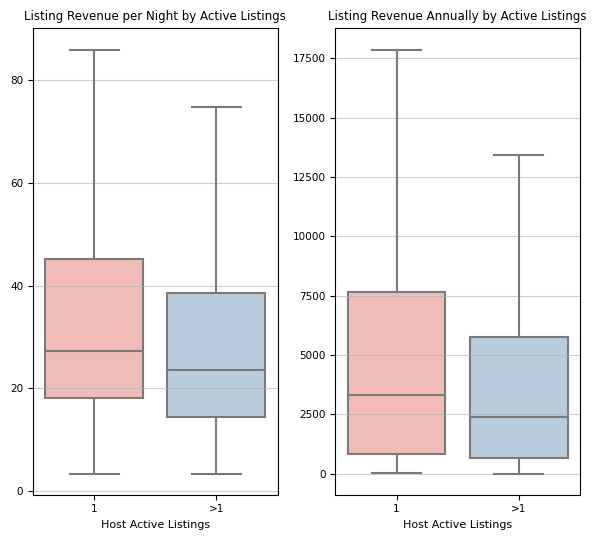

*Note: Outliers Omitted


In [383]:
# figure with two subplots - comparing revenue for hosts with 1 vs >1 active listings
plt.figure(figsize=(6,5.5))

# subplot 1 - revenue per night
plt.subplot(1, 2, 1)
sns.boxplot(x=np.where(ca_host_active_listings['host_total_list_cnt'] == 1, '1', '>1'), y='revenue_nightly', 
            data=ca_host_active_listings, palette='Pastel1', showfliers=False)
plt.title('Listing Revenue per Night by Active Listings', fontsize=8.5)
plt.xlabel('Host Active Listings', fontsize=8)
plt.xticks(fontsize=7.5)
plt.yticks(fontsize=7.5)
plt.ylabel('')
plt.grid(axis='y', alpha=0.6)

# subplot 2 - revenue annually
plt.subplot(1, 2, 2)
sns.boxplot(x=np.where(ca_host_active_listings['host_total_list_cnt'] == 1, '1', '>1'), y='approx_revenue_yr', 
            data=ca_host_active_listings, palette='Pastel1', showfliers=False)
plt.title('Listing Revenue Annually by Active Listings', fontsize=8.5)
plt.xlabel('Host Active Listings', fontsize=8)
plt.xticks(fontsize=7.5)
plt.yticks(fontsize=7.5)
plt.ylabel('')
plt.grid(axis='y', alpha=0.6)

plt.tight_layout()
plt.show()

print('*Note: Outliers Omitted')

- <p style="color:green"><strong>The distribution of listing revenue per night and year is higher for hosts with one active listing than for listings by hosts with multiple</strong></p>

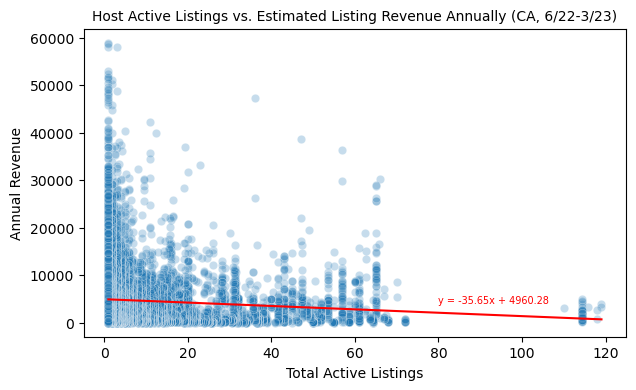

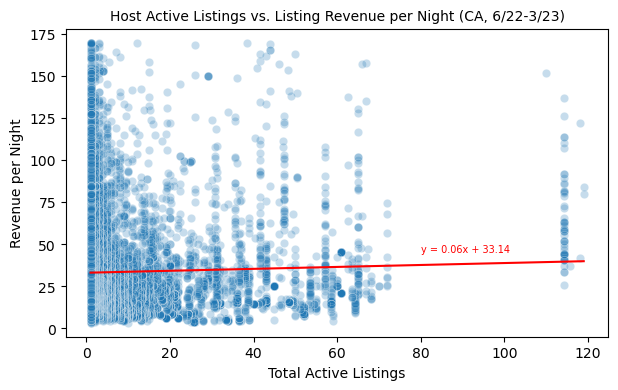

In [274]:
# scatterplot - active listing count vs estimated rev annually
plt.figure(figsize=(7,4))
sns.scatterplot(data=ca_host_active_listings, x='host_total_list_cnt', y='approx_revenue_yr', alpha=0.25)
plt.title('Host Active Listings vs. Estimated Listing Revenue Annually (CA, 6/22-3/23)', fontsize=10)
plt.ylabel('Annual Revenue')
plt.xlabel('Total Active Listings')
# plot trendline and display equation
x = ca_host_active_listings['host_total_list_cnt']
y = ca_host_active_listings['approx_revenue_yr']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='red')
equation = f"y = {z[0]:.2f}x + {z[1]:.2f}"
plt.text(80, 4000, equation, fontsize=7, color="red")
plt.show()

# scatterplot - active listing count vs rev per night
plt.figure(figsize=(7,4))
sns.scatterplot(data=ca_host_active_listings, x='host_total_list_cnt', y='revenue_nightly', alpha=0.25)
plt.title('Host Active Listings vs. Listing Revenue per Night (CA, 6/22-3/23)', fontsize=10)
plt.ylabel('Revenue per Night')
plt.xlabel('Total Active Listings')
# plot trendline and display equation
x = ca_host_active_listings['host_total_list_cnt']
y = ca_host_active_listings['revenue_nightly']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='red')
equation = f"y = {z[0]:.2f}x + {z[1]:.2f}"
plt.text(80, 45, equation, fontsize=7, color="red")
plt.show()

- As can be seen in the first scatterplot and the trendline, there looks to be a reasonably moderate negative relationship between host active listing count and annual revenue
  - For each additional active listing a host has, the expected listing revenue annually drops \\$35.65
- However, there's a near negligible positive linear relationship between between active listings and revenue per night

**Correlations - Listing Revenue and Host's Active Listings:**

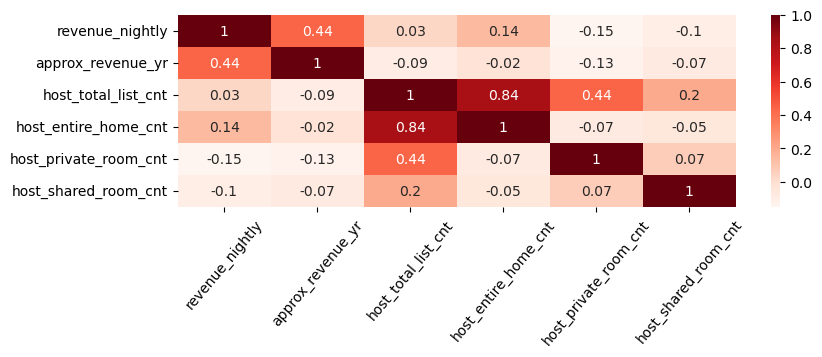

In [451]:
# correlations
cols = ['revenue_nightly','approx_revenue_yr','host_total_list_cnt','host_entire_home_cnt',
        'host_private_room_cnt','host_shared_room_cnt']
active_list_corr = round(ca_host_active_listings[cols].corr(), 2)
# correlation matrix heatmap
plt.figure(figsize=(9,2.5))
sns.heatmap(active_list_corr, annot=True, cmap='Reds')
plt.xticks(rotation=50)
plt.show()

- Based on these correlation coefficients, there aren't any strong relationships, positive or negative, between host active listing measures and listing revenue per night / year


- There are some weak correlations, like...
  - active entire home listings has a weak positive relationship with revenue per night (coefficient: 0.14)
  - active private room listings has a weak negative relationship with revenue per night and revenue annually (coefficients: -0.15, -0.13)

- <p style="color:green"><strong>Listings from hosts with only one active listings made more revenue, on average, than those from hosts with multiple active listings</strong></p>
  - However, overall there is not a strong relationship between a host's total active listings and the amount of revenue from their listings

<a name="superhost"></a>
<h4> <p style="color:orange"><strong>3b - Superhost Status:</strong></p> </h4>

- Do Superhost listings earn more than Non-Superhost listings?

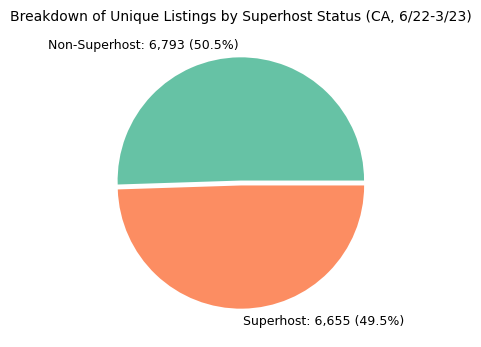

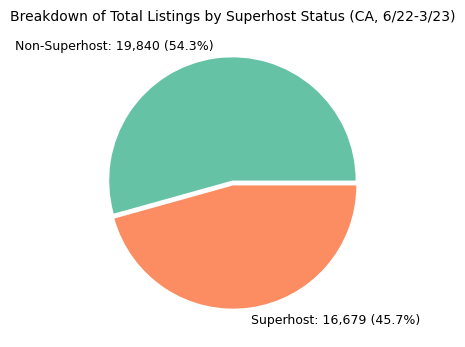

In [238]:
# group by listing_id and get the max value of host_is_superhost to determine listing host's status
grouped_listing_superhost = cali_listings_df.groupby('listing_id')['host_is_superhost'].max()

# unique listings count - superhosts vs. non-superhosts
superhost_list_cnt_grouped = grouped_listing_superhost.value_counts()

# pie chart - unique listings by superhosts vs. non-superhosts
labels = ['Non-Superhost', 'Superhost']
plt.figure(figsize=(4,4))
plt.pie(superhost_list_cnt_grouped, labels=[f'{labels[i]}: {count:,} ({count/sum(superhost_list_cnt_grouped)*100:.1f}%)' for i, (_, count) in enumerate(superhost_list_cnt_grouped.items())], 
        colors=plt.cm.Set2.colors, explode = (0.02, 0.02),textprops={'fontsize': 9})
plt.title('Breakdown of Unique Listings by Superhost Status (CA, 6/22-3/23)', fontsize=10)
plt.show()

# pie chart - total listings by superhosts vs. non-superhosts
plt.figure(figsize=(4,4))
plt.pie(superhost_list_counts, labels=[f'{labels[i]}: {count:,} ({count/sum(superhost_list_counts)*100:.1f}%)' for i, (_, count) in enumerate(superhost_list_counts.items())], 
        colors=plt.cm.Set2.colors, explode = (0.02, 0.02),textprops={'fontsize': 9})
plt.title('Breakdown of Total Listings by Superhost Status (CA, 6/22-3/23)', fontsize=10)
plt.show()

- There was a near even split of listings from Superhosts and listings from Non-Superhosts in California from 6/22 to 3/23 (unique listing count, not cumulative listings)
  - However, looking at total listings by status, can see that Non-Superhosts had more cumulative listings than Superhosts 
    - Non-Superhosts have to list their properties more often - explanation may be that guests stay for longer at Superhost properties, so they don't need to list them for rent as frequently

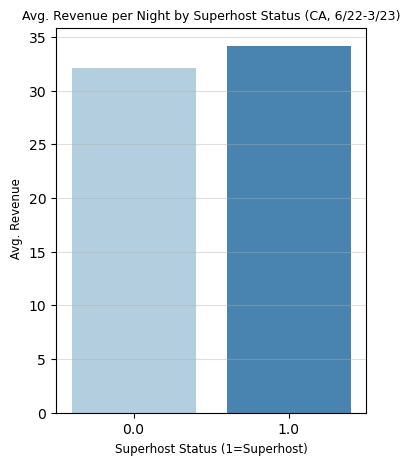

Avg. Annual Revenue by Status: 
 Superhosts: 6489.09 
 Non-Superhosts: 3736.15 



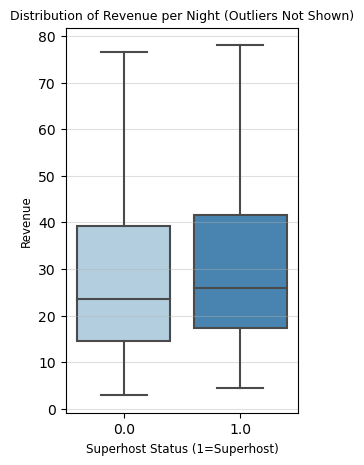

In [281]:
# bar chart distribution of avg rev per night, superhosts vs non-superhosts
plt.figure(figsize=(4,5))
sns.barplot(x='host_is_superhost', y='revenue_nightly', data=cali_listings_df, palette='Blues', ci=None)
plt.title('Avg. Revenue per Night by Superhost Status (CA, 6/22-3/23)', fontsize=9)
plt.xlabel('Superhost Status (1=Superhost)', fontsize=8.5)
plt.ylabel(' Avg. Revenue', fontsize=8.5)
plt.grid(axis='y', alpha=0.4)
plt.show()

# avg revenue by status
super_avg_rev = round(cali_listings_df.loc[cali_listings_df['host_is_superhost'] == 1,'approx_revenue_yr'].mean(), 2)
not_super_avg_rev = round(cali_listings_df.loc[cali_listings_df['host_is_superhost'] == 0,'approx_revenue_yr'].mean(), 2)
print('Avg. Annual Revenue by Status:','\n','Superhosts:',super_avg_rev, '\n','Non-Superhosts:', not_super_avg_rev,'\n')

# boxplot - nightly rev by superhost status
plt.figure(figsize=(3,5))
sns.boxplot(x='host_is_superhost', y='revenue_nightly', data=cali_listings_df, palette='Blues', showfliers=False)
plt.title('Distribution of Revenue per Night (Outliers Not Shown)', fontsize=9)
plt.xlabel('Superhost Status (1=Superhost)', fontsize=8.5)
plt.ylabel('Revenue', fontsize=8.5)
plt.grid(axis='y', alpha=0.4)
plt.show()

<p style="color:green"><strong>Superhost listings made more revenue per night, on average, than Non-Superhost listings did (CA, 6/22-3/23)</strong></p>


  - The median and IQR (middle 50%) of revenue per night is also higher for Superhosts, as shown on the boxplot
    - Both had outliers up to ~\\$170 per night

**Kruskal-Wallis Test:**

In [273]:
# Kruskal-Wallis test
hosts = cali_listings_df['host_is_superhost'].unique()
grouped_rev = [cali_listings_df[cali_listings_df['host_is_superhost'] == host]['revenue_nightly'] for host in hosts]
kruskal_test = kruskal(*grouped_rev)
print('Kruskal-Wallis Test Result:','\n','H-statistic:',kruskal_test.statistic,'\n','p-value:', kruskal_test.pvalue)

Kruskal-Wallis Test Result: 
 H-statistic: 265.1282700114638 
 p-value: 1.308328563223404e-59


- <p style="color:green"><strong>The test results indicate a significant difference in revenue per night between superhost and non-superhost listings (high H-stat, low p-value)</strong></p>

<a name="hostratings"></a>
<h4> <p style="color:orange"><strong>3c - Host-Related Ratings:</strong></p> </h4>


- How do communication and check-in ratings of listings influence revenue from them?

**Distribution of Communication and Check-In Ratings:**

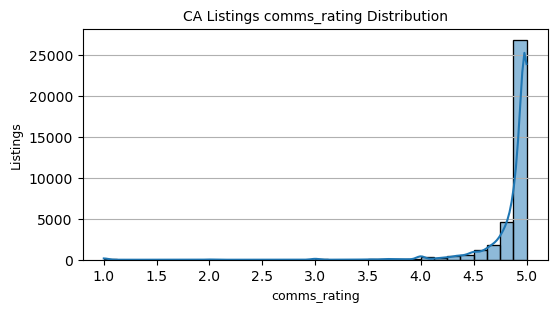

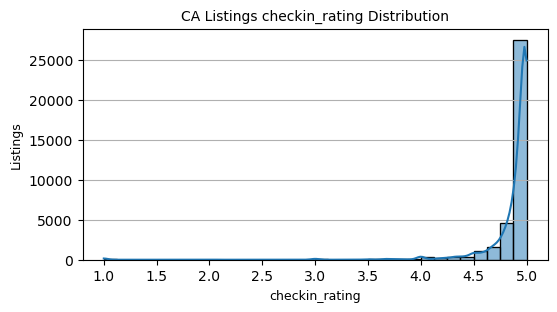

In [282]:
# distribution of ratings
ratings = cali_listings_df[['comms_rating', 'checkin_rating']]

for column in ratings.columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=ratings, x=column, kde=True, bins=32, alpha=0.5)
    plt.title(f'CA Listings {column} Distribution', fontsize=10)
    plt.xlabel(column, fontsize=9)
    plt.ylabel('Listings', fontsize=9)
    plt.grid(axis='y')
    plt.show()

In [283]:
# grouped by listing id, calculate avg revenue and ratings
avg_rev_host_rates = cali_listings_df.groupby('listing_id')[['revenue_nightly','approx_revenue_yr',
                                                             'comms_rating','checkin_rating']].mean().sort_values(by='revenue_nightly',ascending=False).reset_index()
avg_rev_host_rates.describe()

,listing_id,revenue_nightly,approx_revenue_yr,comms_rating,checkin_rating
count,13448.00,13448.00,13448.00,13448.00,13448.00
mean,177958070814482528.00,33.58,4669.25,4.85,4.86
std,298385830080876864.00,26.78,5815.94,0.36,0.34
min,2732.00,3.40,8.97,1.00,1.00
25%,24375785.75,15.90,714.29,4.86,4.87
50%,44955871.00,25.41,2682.76,4.96,4.96
75%,561492228770545600.00,41.82,6555.69,5.00,5.00
max,844425825212996352.00,170.00,58947.50,5.00,5.00


**Scatterplots - Avg. Host Ratings vs Revenue by Listing:**

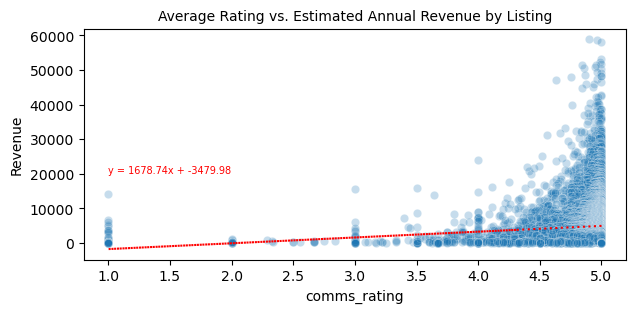

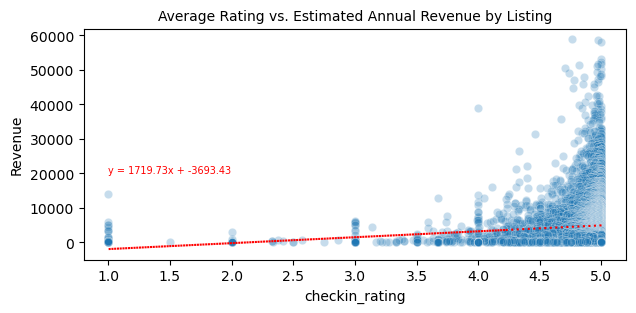

In [291]:
ratings = ['comms_rating', 'checkin_rating']

for rating in ratings:
    plt.figure(figsize=(7,3))
    sns.scatterplot(x=rating, y='approx_revenue_yr', data=avg_rev_host_rates, alpha=0.25)
    plt.title('Average Rating vs. Estimated Annual Revenue by Listing', fontsize=10)
    plt.ylabel('Revenue')
    plt.xlabel(rating)
    x = avg_rev_host_rates[rating]
    y = avg_rev_host_rates['approx_revenue_yr']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='red', linestyle=':')
    equation = f'y = {z[0]:.2f}x + {z[1]:.2f}'
    plt.text(1, 20000, equation, fontsize=7, color='red')
    plt.show()

**Correlations Between Avg. Host Ratings and Revenue:**

Correlations Between Avg. Host-Related Ratings and Avg. Revenue - CA Listings (6/22-3/23): 



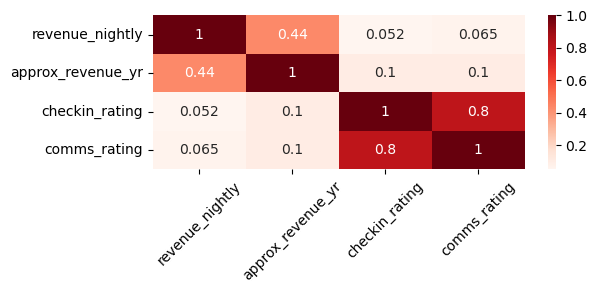

In [294]:
# create correlation matrix
corr_matrix = avg_rev_host_rates[['revenue_nightly','approx_revenue_yr','checkin_rating','comms_rating']].corr()

# heatmap using seaborn
plt.figure(figsize=(6,2))
sns.heatmap(corr_matrix, annot=True, cmap='Reds')
plt.xticks(rotation=45)

print('Correlations Between Avg. Host-Related Ratings and Avg. Revenue - CA Listings (6/22-3/23):','\n')
plt.show()

- <p style="color:green"><strong>Given the correlation coefficients above, there is not a meaningful relationship between avg. revenue per night and year with communication and check-in ratings</strong></p>
  - There are weak positive correlations between estimated annual revenue and communication / check-in ratings for listings (both corr coefficients: 0.1)

<h3> <p style="color:red"><strong>Insights and concluding thoughts included in Tableau presentation</strong></p> </h3>